# 0 Setup

## 0.0 Euntime environment packages

In [89]:
%pip install numpy
%pip install pandas
%pip install scanpy
%pip install igraph
%pip install louvain
%pip install leidenalg
%pip install anndata
%pip install gdown -q
%pip install harmony-pytorch
# %pip install magic-impute
%pip install scanpy-magic --no-deps
%pip install harmonypy
# %pip install --upgrade --force-reinstall numpy pandas scipy scikit-learn anndata scanpy harmonypy


import scanpy as sc
import numpy as np
import os
import anndata
from sklearn import metrics
import pandas as pd
import warnings
import seaborn as sns
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import matplotlib.colors as mpl_colors
import matplotlib.pyplot as plt




ERROR: Could not find a version that satisfies the requirement scanpy-magic (from versions: none)
ERROR: No matching distribution found for scanpy-magic


## 0.1 Fetch data using gdown

In [90]:
!gdown --id 1gkr16CbHYIXDVw9ggN8rBvGZq_llDvxD -O cleaned_processed_frogtail.h5ad
local_filename = 'cleaned_processed_frogtail.h5ad'

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1gkr16CbHYIXDVw9ggN8rBvGZq_llDvxD
From (redirected): https://drive.google.com/uc?id=1gkr16CbHYIXDVw9ggN8rBvGZq_llDvxD&confirm=t&uuid=c55bfd28-3bf9-4139-91a2-35c25be5f61a
To: /content/cleaned_processed_frogtail.h5ad
100% 355M/355M [00:02<00:00, 155MB/s]


## 0.2 Read data from .h5ad file

In [91]:
file_path = os.path.abspath(local_filename) # this fails if local_filename has not been declared in previous cell

# 1. Check if the file exists at the local path
if os.path.exists(file_path):
    try:
        # 2. Read the H5AD file directly
        adata = anndata.read_h5ad(file_path)

        print("\n✅ Success! AnnData object loaded.")
        print("\n--- AnnData Object Summary ---")
        print(adata)

        # Display key metadata
        print("\nFirst 5 rows of Cell Metadata (adata.obs):")
        print(adata.obs.head())

        print("\nFirst 5 rows of Gene Metadata (adata.var):")
        print(adata.var.head())

    except Exception as e:
        print(f"\n❌ Error during anndata read: {e}")
        print("This typically means the file is corrupted or not a valid H5AD format.")
        print("Please check the integrity of your manually downloaded file.")

else:
    print("\n❌ File not found.")
    print(f"Please ensure the file '{file_path}' exists in the current working directory.")


✅ Success! AnnData object loaded.

--- AnnData Object Summary ---
AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'

First 5 rows of Cell Metadata (adata.obs):
        barcode_cells                cell  sample DevelopmentalStage  \
0  AAACCTGAGCTAGTTC.1  AAACCTGAGCTAGTTC.1  SIGAB5               st40   
1  AAACCTGGTGGGTCAA.1  AAACCTGGTGGGTCAA.1  SIGAB5               st40   
2  AAACCTGGTTTGTTGG.1  AAACCTGGTTTGTTGG.1  SIGAB5               st40   
3  AAACGGGGTCGGCATC.1  AAACGGGGTCGGCATC.1  SIGAB5               st40   
4  AAACGGGTCCTACAGA.1  AAACGGGTCCTACAGA.1  SIGAB5               st40   

   DaysPostAmputation        cluster         X         Y CellCyclePhase  \
0                   3  Erythrocyte 4 -6.40e+00  8.32e-01            G2M   
1                   3      Myeloid 1 -2.43e+00  1.38e+01             G1   
2             

/usr/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


# 1 Clustering Analysis:


*  Use at least two clustering algorithms (e.g., PCA + Louvain, PCA + Leiden, kNN).
* Generate figures to visualize the clusters.
* Compute clustering metrics (e.g., RAND-index, silhouette score, ARI).
* Optionally, explore a metric not discussed in class for bonus points.



**Preprocessing and clustering**
*- Scanpy documentation - tutorials*
*https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html*



## 1.0 Quality control

https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html#quality-control

In [92]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)


### Doublet detection
https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html#doublet-detection

In [93]:
sc.pp.scrublet(adata, batch_key="sample")
adata = adata[~adata.obs['predicted_doublet'], :].copy()


## 1.1 Normalization
https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html#normalization

In [94]:
adata.layers["counts"] = adata.X.copy()     # Saving count data - scapy docs
adata_copy = adata.copy()    # create a copy of data to alter
sc.pp.normalize_total(adata_copy) # Normalizing to median total counts - scanpy docs
sc.pp.log1p(adata_copy) # Logarithmize the data - scanpy docs

## 1.2 Feature selection
https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html#feature-selection

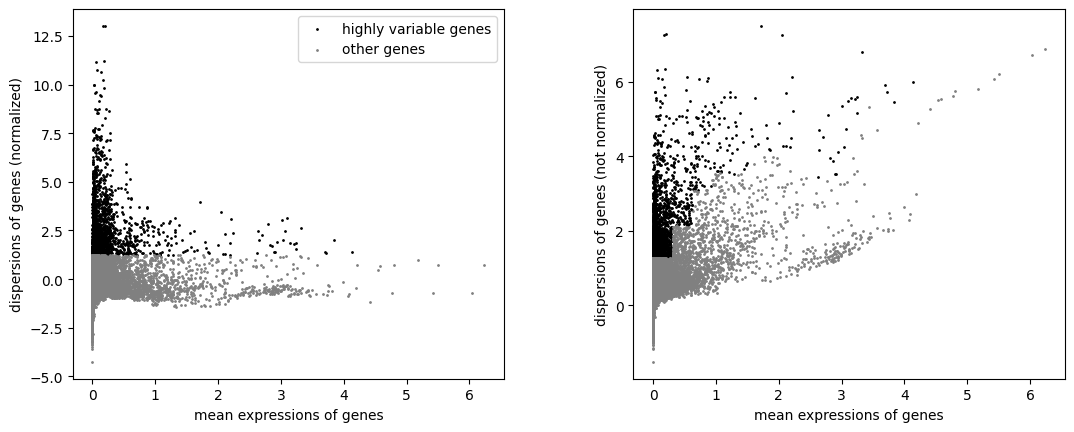

In [95]:
sc.pp.highly_variable_genes(adata_copy, n_top_genes=2000)
sc.pl.highly_variable_genes(adata_copy)

## 1.3 Dimensionality Reduction
https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html#dimensionality-reduction

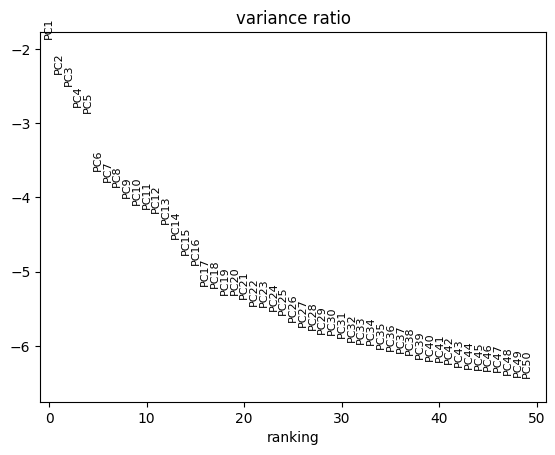

In [96]:
sc.pp.pca(adata_copy, n_comps=50)
sc.pl.pca_variance_ratio(adata_copy, n_pcs=50, log=True)

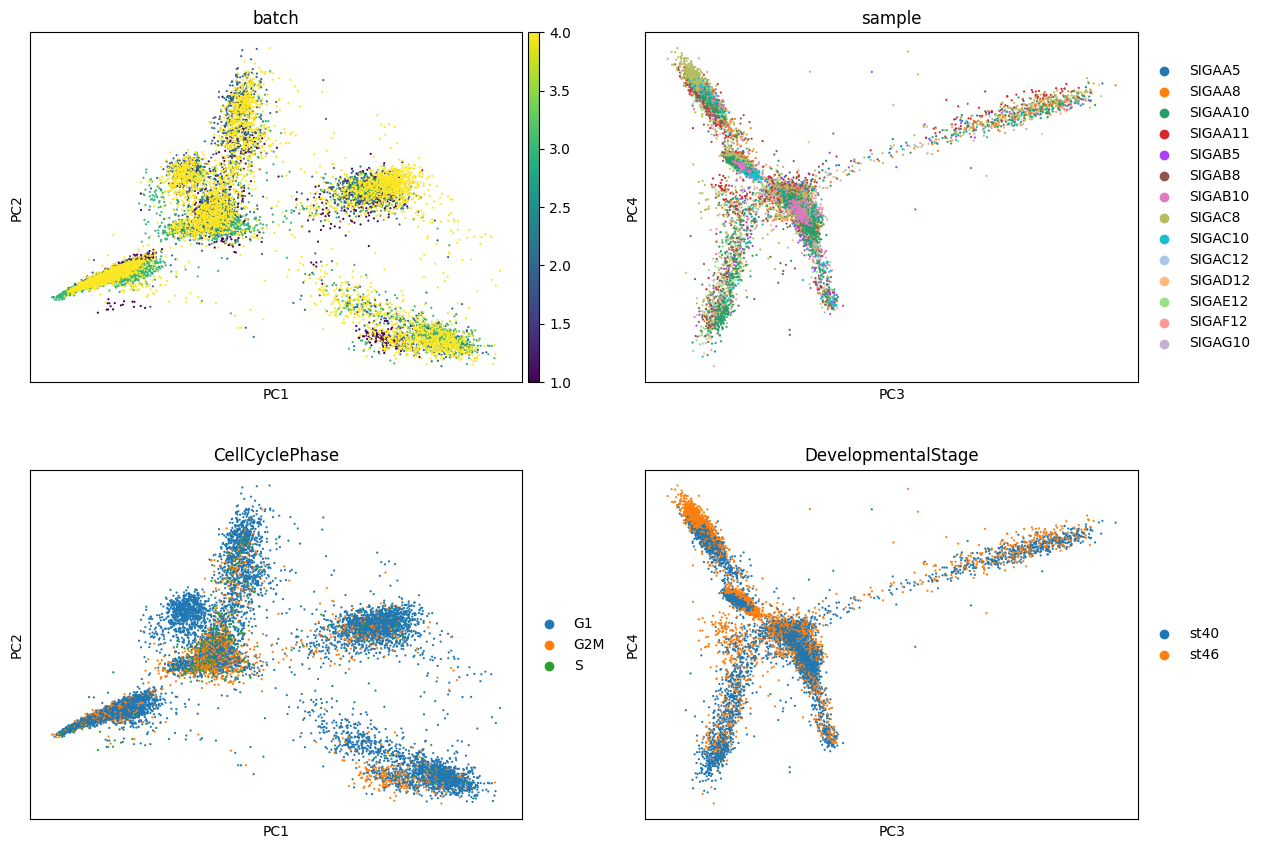

In [97]:
        # Plot 3b: PCA Scatter Plots (Checking for batch and cell cycle effects)
        # Plots the top PCs (PC1 vs PC2 and PC3 vs PC4) colored by metadata.
        # Note: We use 'batch', 'sample', and 'CellCyclePhase' from the obs table.
        # This checks if variation is driven by technical noise rather than biology.
sc.pl.pca(
    adata_copy,
    color=["batch", "sample", "CellCyclePhase", "DevelopmentalStage"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)], # Plotting PC1/PC2 and PC3/PC4
    ncols=2,
    size=10,
    # title="PCA Scatter Plots: Checking for Batch/Cell Cycle Effects",
    show=True)

## 1.4 Nearest neighbor graph

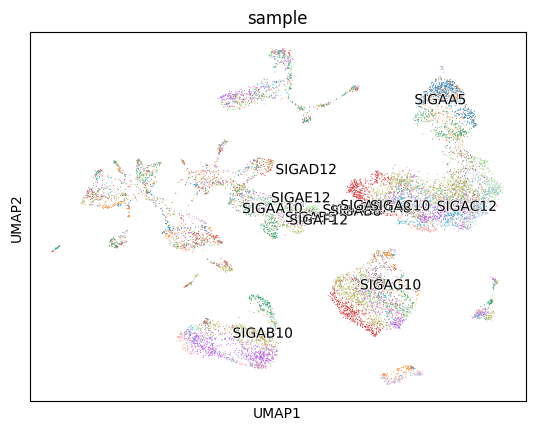

In [98]:
sc.pp.neighbors(adata_copy) # k-NN graph
sc.tl.umap(adata_copy)
sc.pl.umap(
    adata_copy,
    legend_loc="on data",
    legend_fontoutline=1,
    legend_fontweight="normal",
    ncols=1,
    # title="UMAP",
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

## 1.5 Clustering

In [99]:
def set_colorblind_palette(adata, obs_name, palette_name="tab20"):
    """
    Apply a Seaborn color palette (default: husl) to a categorical obs column in an AnnData object.
    Ensures enough distinct colors even if there are many categories.
    """
    # Ensure column exists
    if obs_name not in adata.obs:
        raise ValueError(f"'{obs_name}' not found in adata.obs")

    # Make sure the column is categorical
    adata.obs[obs_name] = pd.Categorical(adata.obs[obs_name])
    n = adata.obs[obs_name].nunique()

    # Generate enough colors (repeat the palette if too short)
    base_colors = sns.color_palette(palette_name, n_colors=min(n, 10)).as_hex()
    # if n > len(base_colors):
    #     # extend by cycling through the base palette
    #     colors = (base_colors * ((n // len(base_colors)) + 1))[:n]
    # else:
    #     colors = base_colors

    # Store in AnnData
    adata.uns[f"{obs_name}_colors"] = base_colors

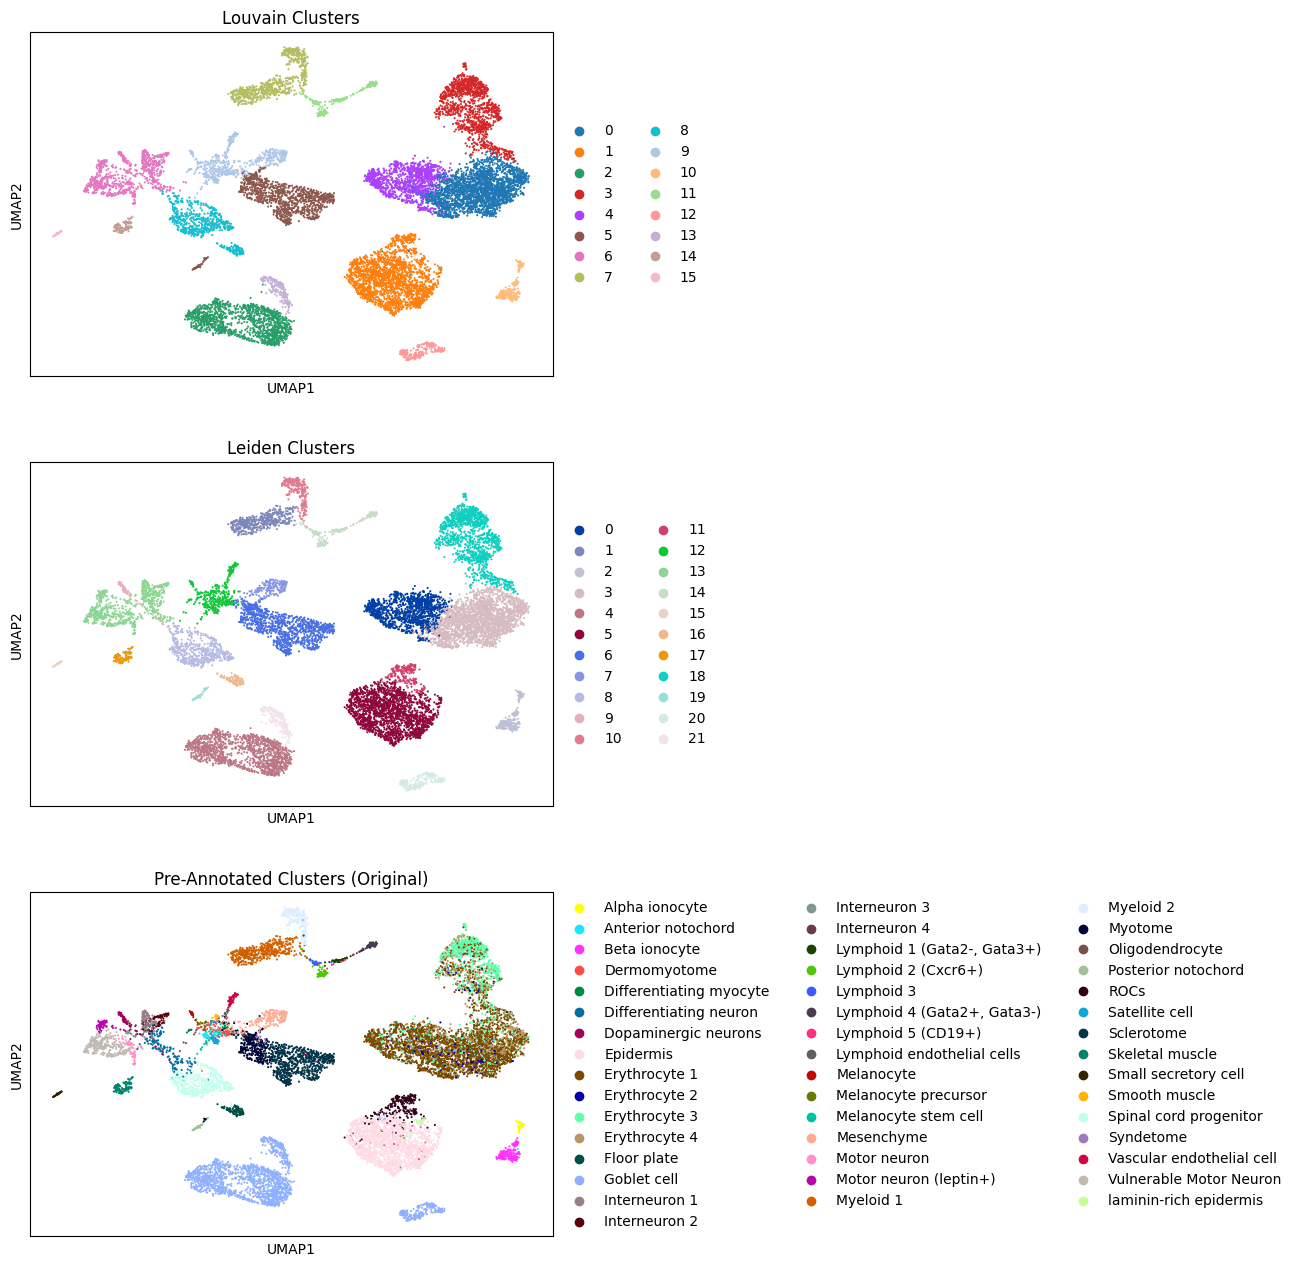

In [100]:
sc.tl.louvain(adata_copy, key_added='louvain_clusters', resolution=0.4) # clustering 1 louvain
sc.tl.leiden(adata_copy, key_added='leiden_clusters', flavor="igraph", n_iterations=2, resolution=0.4) # clustering 2 leiden
sc.tl.umap(adata_copy) # UMAP embedding

to_do = ['louvain_clusters', 'leiden_clusters', 'cluster']

for stak in to_do:
  set_colorblind_palette(adata_copy, obs_name=stak)

sc.pl.umap(adata_copy,
                color=to_do,
                title=['Louvain Clusters', 'Leiden Clusters', 'Pre-Annotated Clusters (Original)'],
                show=True,
          #  legend_loc="on data",
           legend_fontoutline=1,
           legend_fontweight="normal",
            ncols=1
            # Explicitly provide palette names instead of None for the first two plots
            # palette=['default', 'plasma', cluster_colors]
           )

## 1.6 Clustering performance evaluation

* Compute clustering metrics (e.g., RAND-index, silhouette score, ARI).
* Optionally, explore a metric not discussed in class for bonus points.

### 1.6.a RAND-index & ARI

https://scikit-learn.org/stable/modules/clustering.html#rand-index

The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:

ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score

In [101]:
# RAND checks known truth against our predicted labels.
labels_known = adata_copy.obs['cluster'].astype(str)
labels_leiden = adata_copy.obs['leiden_clusters'].astype(str)
labels_louvain = adata_copy.obs['louvain_clusters'].astype(str)
print(f'Leiden randscore: {metrics.rand_score(labels_known,labels_leiden):.3f}')
print(f'Louvain randscore; {metrics.rand_score(labels_known,labels_louvain):.3f}')
print('Perfect labeling is scored 1.0:')
print(f'Leiden adjusted randscore: {metrics.adjusted_rand_score(labels_known,labels_leiden):.3f}')
print(f'Louvain adjusted randscore; {metrics.adjusted_rand_score(labels_known,labels_louvain):.3f}')


Leiden randscore: 0.927
Louvain randscore; 0.918
Perfect labeling is scored 1.0:
Leiden adjusted randscore: 0.582
Louvain adjusted randscore; 0.553


In [102]:
print(np.isin(np.array(['ROCs']),labels_known))

[ True]


### 1.6.b Silhouette score

https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

In [103]:
# For unknow truth labels we check against the model itself
# a: The mean distance between a sample and all other points in the same class.
# b: The mean distance between a sample and all other points in the next nearest cluster.

# s = (b - a)/max(a,b)
print(f'leiden silhouette score: {metrics.silhouette_score(adata_copy.obsm['X_pca'], adata_copy.obs['leiden_clusters'].astype(str), metric='euclidean'):.3f}')
print(f'louvain silhouette score: {metrics.silhouette_score(adata_copy.obsm['X_pca'], adata_copy.obs['louvain_clusters'].astype(str), metric='euclidean'):.3f}')

leiden silhouette score: 0.330
louvain silhouette score: 0.317


### 1.6.c Mutual Information

Since in our case we know the ground truth it makes sense to try another ground truth based metric from the scikit library


---


https://scikit-learn.org/stable/modules/clustering.html#mutual-information-based-scores

In [104]:
for key, value in {'leiden' : labels_leiden,'louvain': labels_louvain}.items():
  print(f'--- {key}')
  print(f'{key} Mutual information: {metrics.mutual_info_score(labels_known, value):.3f}')
  print(f'{key} Normalized mutual informtion (NMI): {metrics.normalized_mutual_info_score(labels_known, value):.3f}')
  print(f'{key} Adjusted mutual information (AMI): {metrics.adjusted_mutual_info_score(labels_known, value):.3f}')

--- leiden
leiden Mutual information: 2.061
leiden Normalized mutual informtion (NMI): 0.761
leiden Adjusted mutual information (AMI): 0.757
--- louvain
louvain Mutual information: 1.906
louvain Normalized mutual informtion (NMI): 0.727
louvain Adjusted mutual information (AMI): 0.725


# 2 Marker Selection and Gene Analysis:
* Use at least two marker selection methods to identify genes that define the ROC.
* Compare the identified markers across different methods.
* Compare your gene set with the genes listed in Supplementary Table 3.
* Optionally, perform Gene Ontology (GO) analysis to explore the biological roles of these genes in other context

## 2.0 Investigate known location of markers

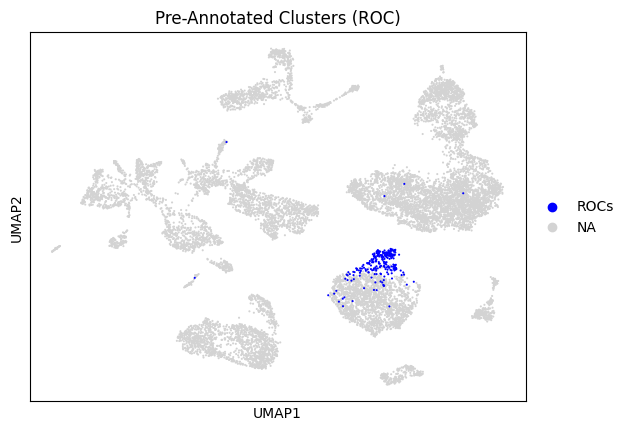

In [105]:
adata_copy.obs['cluster'] = pd.Categorical(adata_copy.obs['cluster'])
categories = list(adata_copy.obs['cluster'].cat.categories)

colors = ['blue' if c == 'ROCs' else 'grey' for c in categories]

# sanity check (must match)
assert len(colors) == len(categories), "number of colors must equal number of categories"

# --- store a list (not a dict) at the key "<obs_name>_colors" or "<obs_name>_colors" ---
# Scanpy looks for adata.uns['cluster_colors'] when plotting the 'cluster' obs.
adata_copy.uns['cluster_colors'] = colors

sc.pl.umap(adata_copy,
                color=['cluster'],
                title=['Pre-Annotated Clusters (ROC)'],
                show=True,
           groups=['ROCs'],
          #  legend_loc="on data",
           legend_fontoutline=1,
           legend_fontweight="normal",
            ncols=1
          #  palette=3*['tab20']
            # Explicitly provide palette names instead of None for the first two plots
            # palette=['viridis', 'plasma', cluster_colors]
           )

We see that ROC is mostly located in cluster 1 from the louvain clusters.

Leiden clusters show two clusters there 5 and 11.

11 being the ""core"" of the ROCs cluster, we can then assume that 5 and 11 have many genes incommon and are the sub clusters of the louvain cluster 1.


This does not feel very robust, we must be able to proof that these are ROC genes with some hypothesis.

My claim is that the genes that initiate the reconstructive process would be displayed soon after amputation. This would prevent the wound from healing in another way and prepare it for the reconstruction. New reconstructed cells would increase in value following the reconstruction process.

In order to find we will look for more prominent cells/leiden clusters at day 0 from amputation and at st40 and compare them.

*Top marker functions*

## 2.1 Find marker

In [106]:
def get_top_markers(adata, method_key, group_id=None, n_genes=5):
    """Extracts and formats the top N marker genes from rank_genes_groups results."""
    # Build the column key, e.g., 'rank_genes_groups_wilcoxon'

    if method_key not in adata.uns:
        print(f"Error: Marker gene results not found at adata.uns['{method_key}']")
        return []

    # Use scanpy utility to extract results into a DataFrame
    df = sc.get.rank_genes_groups_df(adata, key=method_key, group=group_id)

    # Return a concise list of the top N gene names
    return df['names'].head(n_genes).tolist()

### 2.1.a clusters at day 0 for leiden

In [107]:
# --- 1. Data Preparation ---
target_day = '0' # Use string representation matching your metadata
print(f"-> Creating Contingency Table for DPA {target_day} vs. All Other Cells...")

# Create a binary column for the comparison
# Assuming 'leiden_clusters' and 'DaysPostAmputation' are in adata_copy.obs
adata_copy.obs['Is_DPA2'] = adata_copy.obs['DaysPostAmputation'].astype(str).apply(
    lambda x: f'DPA_{target_day}' if x == target_day else 'Other_DPA'
)

# Contingency table: Clusters (Rows) vs. DPA_2 (Columns)
contingency_table = pd.crosstab(
    index=adata_copy.obs['leiden_clusters'],
    columns=adata_copy.obs['Is_DPA2'],
    normalize=False
)

# Handle cases where the target column might be missing if no cells are DPA 2
target_col = f'DPA_{target_day}'
if target_col not in contingency_table.columns:
    print(f"❌ WARNING: No cells found with DaysPostAmputation = {target_day}. All clusters will show no enrichment.")
    # Pad the table to prevent errors in the loop
    contingency_table[target_col] = 0

# --- 2. Calculate Totals and Initialize Results ---
total_target = contingency_table[target_col].sum()
total_other = contingency_table['Other_DPA'].sum()
results = {}

# --- 3. Perform Fisher's Exact Test for Each Cluster ---
print(f"-> Running Fisher's Exact Test for enrichment in DPA {target_day}...")
p_values = []

for cluster_id in contingency_table.index:
    n_cluster_target = contingency_table.loc[cluster_id, target_col]
    n_cluster_other = contingency_table.loc[cluster_id, 'Other_DPA']

    n_other_target = total_target - n_cluster_target
    n_other_other = total_other - n_cluster_other

    # 2x2 table: [[Cluster N_target, Cluster N_other], [Other N_target, Other N_other]]
    table = [
        [n_cluster_target, n_cluster_other],
        [n_other_target, n_other_other]
    ]

    # Test for enrichment in the target DPA
    or_val, p_val = fisher_exact(table, alternative='greater')
    p_values.append(p_val)

    results[cluster_id] = {
        f'N_DPA_{target_day}': n_cluster_target,
        'N_Other': n_cluster_other,
        f'OR_DPA_{target_day}_v_Other': or_val,
    }

# Convert results to DataFrame
enrichment_df = pd.DataFrame.from_dict(results, orient='index')

# --- 4. Apply FDR Correction (Benjamini-Hochberg) ---
print("-> Applying FDR Correction...")
_, fdr_pvalues, _, _ = multipletests(p_values, method='fdr_bh')
enrichment_df['FDR_DPA_Enriched'] = fdr_pvalues

# --- 5. Determine Significance and Display Results ---
SIGNIFICANCE_THRESHOLD = 0.01
enrichment_df[f'DPA_{target_day}_Characteristic'] = (
    (enrichment_df['FDR_DPA_Enriched'] < SIGNIFICANCE_THRESHOLD) &
    (enrichment_df[f'OR_DPA_{target_day}_v_Other'] > 1)
)

pd.set_option('display.float_format', '{:.2e}'.format)
enrichment_df = enrichment_df.sort_values(by=f'OR_DPA_{target_day}_v_Other', ascending=False)

print(f"\n--- Leiden Cluster Enrichment Analysis: DPA {target_day} vs. All Other Cells ---")
print(enrichment_df[[f'N_DPA_{target_day}', 'N_Other', f'OR_DPA_{target_day}_v_Other', 'FDR_DPA_Enriched', f'DPA_{target_day}_Characteristic']])

leiden_dpa_targets = enrichment_df[enrichment_df[f'DPA_{target_day}_Characteristic']].index.tolist()
print(f"\n✅ Clusters Statistically Enriched in DPA {target_day}: {leiden_dpa_targets}")

-> Creating Contingency Table for DPA 0 vs. All Other Cells...
-> Running Fisher's Exact Test for enrichment in DPA 0...
-> Applying FDR Correction...

--- Leiden Cluster Enrichment Analysis: DPA 0 vs. All Other Cells ---
    N_DPA_0  N_Other  OR_DPA_0_v_Other  FDR_DPA_Enriched  DPA_0_Characteristic
20      215        1          3.37e+02          3.65e-84                  True
19       53        2          4.03e+01          1.53e-18                  True
16       73       34          3.26e+00          7.34e-09                  True
0       780      408          3.21e+00          1.09e-77                  True
11      135       73          2.83e+00          6.48e-13                  True
9        48       31          2.34e+00          3.11e-04                  True
7       109       78          2.13e+00          6.19e-07                  True
18      728      566          2.09e+00          4.40e-35                  True
8       312      233          2.08e+00          2.19e-16           

### 2.1.b clusters at day 0 for louvain

In [108]:
# --- 1. Data Preparation ---
target_day = '0' # Use string representation matching your metadata
print(f"-> Creating Contingency Table for DPA {target_day} vs. All Other Cells...")

# Create a binary column for the comparison
# Assuming 'louvain_clusters' and 'DaysPostAmputation' are in adata_copy.obs
adata_copy.obs['Is_DPA2'] = adata_copy.obs['DaysPostAmputation'].astype(str).apply(
    lambda x: f'DPA_{target_day}' if x == target_day else 'Other_DPA'
)

# Contingency table: Clusters (Rows) vs. DPA_2 (Columns)
contingency_table = pd.crosstab(
    index=adata_copy.obs['louvain_clusters'],
    columns=adata_copy.obs['Is_DPA2'],
    normalize=False
)

# Handle cases where the target column might be missing if no cells are DPA 2
target_col = f'DPA_{target_day}'
if target_col not in contingency_table.columns:
    print(f"❌ WARNING: No cells found with DaysPostAmputation = {target_day}. All clusters will show no enrichment.")
    # Pad the table to prevent errors in the loop
    contingency_table[target_col] = 0

# --- 2. Calculate Totals and Initialize Results ---
total_target = contingency_table[target_col].sum()
total_other = contingency_table['Other_DPA'].sum()
results = {}

# --- 3. Perform Fisher's Exact Test for Each Cluster ---
print(f"-> Running Fisher's Exact Test for enrichment in DPA {target_day}...")
p_values = []

for cluster_id in contingency_table.index:
    n_cluster_target = contingency_table.loc[cluster_id, target_col]
    n_cluster_other = contingency_table.loc[cluster_id, 'Other_DPA']

    n_other_target = total_target - n_cluster_target
    n_other_other = total_other - n_cluster_other

    # 2x2 table: [[Cluster N_target, Cluster N_other], [Other N_target, Other N_other]]
    table = [
        [n_cluster_target, n_cluster_other],
        [n_other_target, n_other_other]
    ]

    # Test for enrichment in the target DPA
    or_val, p_val = fisher_exact(table, alternative='greater')
    p_values.append(p_val)

    results[cluster_id] = {
        f'N_DPA_{target_day}': n_cluster_target,
        'N_Other': n_cluster_other,
        f'OR_DPA_{target_day}_v_Other': or_val,
    }

# Convert results to DataFrame
enrichment_df = pd.DataFrame.from_dict(results, orient='index')

# --- 4. Apply FDR Correction (Benjamini-Hochberg) ---
print("-> Applying FDR Correction...")
_, fdr_pvalues, _, _ = multipletests(p_values, method='fdr_bh')
enrichment_df['FDR_DPA_Enriched'] = fdr_pvalues

# --- 5. Determine Significance and Display Results ---
SIGNIFICANCE_THRESHOLD = 0.01
enrichment_df[f'DPA_{target_day}_Characteristic'] = (
    (enrichment_df['FDR_DPA_Enriched'] < SIGNIFICANCE_THRESHOLD) &
    (enrichment_df[f'OR_DPA_{target_day}_v_Other'] > 1)
)

pd.set_option('display.float_format', '{:.2e}'.format)
enrichment_df = enrichment_df.sort_values(by=f'OR_DPA_{target_day}_v_Other', ascending=False)

print(f"\n--- louvain Cluster Enrichment Analysis: DPA {target_day} vs. All Other Cells ---")
print(enrichment_df[[f'N_DPA_{target_day}', 'N_Other', f'OR_DPA_{target_day}_v_Other', 'FDR_DPA_Enriched', f'DPA_{target_day}_Characteristic']])

louvain_dpa_targets = enrichment_df[enrichment_df[f'DPA_{target_day}_Characteristic']].index.tolist()
print(f"\n✅ Clusters Statistically Enriched in DPA {target_day}: {louvain_dpa_targets}")

-> Creating Contingency Table for DPA 0 vs. All Other Cells...
-> Running Fisher's Exact Test for enrichment in DPA 0...
-> Applying FDR Correction...

--- louvain Cluster Enrichment Analysis: DPA 0 vs. All Other Cells ---
    N_DPA_0  N_Other  OR_DPA_0_v_Other  FDR_DPA_Enriched  DPA_0_Characteristic
12      215        1          3.37e+02          2.65e-84                  True
4       739      384          3.21e+00          4.60e-74                  True
8       388      267          2.28e+00          3.87e-24                  True
3       724      561          2.09e+00          2.68e-35                  True
1      1081      993          1.80e+00          4.60e-34                  True
6       398      445          1.37e+00          1.46e-05                  True
9       250      362          1.04e+00          7.56e-01                 False
15       13       22          8.89e-01          1.00e+00                 False
0       648     1718          5.06e-01          1.00e+00          

### 2.1.c shared clusters day 0 clusters

#### plot_highlighted_umap() **FUNCTION**

In [109]:
def plot_highlighted_umap(adata, cluster_key: str, target_clusters: list, plot_title: str):
    """
    Creates a custom color palette for a UMAP plot:
    distinct colors for target clusters, and 'grey' for all others.

    Args:
        adata (AnnData): The AnnData object containing the data and UMAP coordinates.
        cluster_key (str): The column name in adata.obs for the clustering (e.g., 'leiden_clusters').
        target_clusters (list): A list of cluster IDs (strings) to be highlighted.
        plot_title (str): The title for the UMAP plot.
    """

    # --- 1. Define Colors and Categories ---
    # Use the 'tab20' palette for distinct colors
    COLOR_PALETTE = plt.cm.get_cmap('tab20').colors
    GREY_COLOR = 'grey'

    # Ensure the cluster key exists and is categorical
    if cluster_key not in adata.obs.columns:
        raise ValueError(f"Cluster key '{cluster_key}' not found in adata.obs.")

    adata.obs[cluster_key] = adata.obs[cluster_key].astype('category')
    categories = list(adata.obs[cluster_key].cat.categories)

    # --- 2. Build the Custom Color Map ---
    cluster_color_map = {}
    color_index = 0

    # Ensure targets are strings, just in case
    target_clusters = [str(c) for c in target_clusters]

    for category in categories:
        if str(category) in target_clusters:
            # Assign a distinct color from the palette
            cluster_color_map[category] = mpl_colors.to_hex(COLOR_PALETTE[color_index % len(COLOR_PALETTE)])
            color_index += 1
        else:
            # Assign the requested solid 'grey' color to non-target clusters
            cluster_color_map[category] = GREY_COLOR

    # --- 3. Create the final ordered color list for Scanpy ---
    # Scanpy requires a list of colors ordered by the category list
    final_colors = [cluster_color_map[c] for c in categories]

    # Store colors in adata.uns (required by scanpy)
    adata.uns[f'{cluster_key}_colors'] = final_colors

    # --- 4. Generate the UMAP Plot ---
    print(f"-> Generating UMAP for {cluster_key}...")

    sc.pl.umap(adata,
               color=[cluster_key],
               title=[plot_title],
               show=True,
               # Only show target clusters in the legend for clarity
               groups=target_clusters,
               legend_loc="on data",
               legend_fontoutline=2,
               legend_fontweight="normal",
               ncols=1
              )

-> Generating UMAP for leiden_clusters...


/tmp/ipython-input-3148644050.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  COLOR_PALETTE = plt.cm.get_cmap('tab20').colors


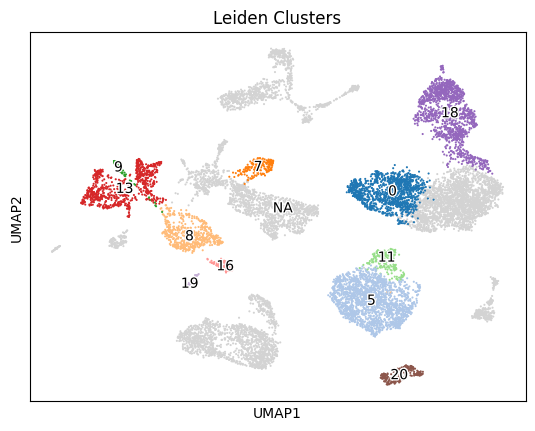

-> Generating UMAP for louvain_clusters...


/tmp/ipython-input-3148644050.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  COLOR_PALETTE = plt.cm.get_cmap('tab20').colors


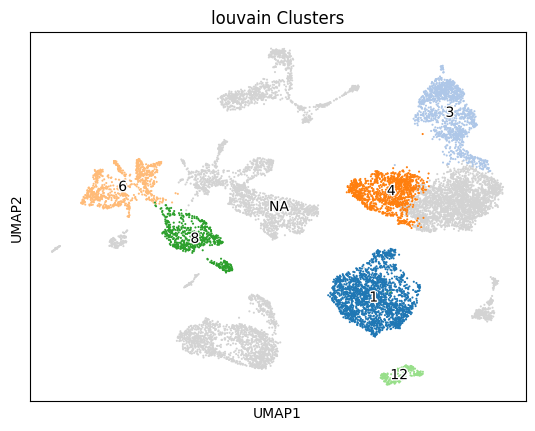

In [110]:
plot_highlighted_umap(adata_copy, 'leiden_clusters', leiden_dpa_targets, 'Leiden Clusters')
plot_highlighted_umap(adata_copy, 'louvain_clusters', louvain_dpa_targets, 'louvain Clusters')

### 2.1.d Leiden developmental stag st40 vs st46

In [111]:
# --- 1. Create the Contingency Table (st40 vs st46) ---
print("-> Creating Contingency Table (Leiden Clusters vs. Developmental Stage)...")
contingency_table = pd.crosstab(
    index=adata_copy.obs['leiden_clusters'],
    columns=adata_copy.obs['DevelopmentalStage'],
    normalize=False
)

# --- 2. Calculate Totals and Initialize Results ---
total_st46 = contingency_table['st46'].sum()
total_st40 = contingency_table['st40'].sum()
results = {}
p_values_st40 = []

# --- 3. Perform Fisher's Exact Test for st40 Enrichment ---
print("-> Running Fisher's Exact Test for st40 Enrichment...")

for cluster_id in contingency_table.index:
    n_cluster_st46 = contingency_table.loc[cluster_id, 'st46']
    n_cluster_st40 = contingency_table.loc[cluster_id, 'st40']

    n_other_st46 = total_st46 - n_cluster_st46
    n_other_st40 = total_st40 - n_cluster_st40

    # Table for st40 enrichment: [[Cluster N_st40, Cluster N_st46], [Other N_st40, Other N_st46]]
    table_st40 = [
        [n_cluster_st40, n_cluster_st46],
        [n_other_st40, n_other_st46]
    ]
    # alternative='greater' tests if OR > 1 for st40
    or_st40, p_st40 = fisher_exact(table_st40, alternative='greater')
    p_values_st40.append(p_st40)

    results[cluster_id] = {
        'N_st40': n_cluster_st40,
        'N_st46': n_cluster_st46,
        'OR_st40_v_st46': or_st40,
    }

# Convert results to DataFrame
enrichment_df = pd.DataFrame.from_dict(results, orient='index')

# --- 4. Apply FDR Correction (Benjamini-Hochberg) ---
print("-> Applying FDR Correction...")
_, fdr_st40, _, _ = multipletests(p_values_st40, method='fdr_bh')
enrichment_df['FDR_st40_Enriched'] = fdr_st40

# --- 5. Determine Significance ---
SIGNIFICANCE_THRESHOLD = 0.05
enrichment_df['st40_Characteristic'] = (
    (enrichment_df['FDR_st40_Enriched'] < SIGNIFICANCE_THRESHOLD) &
    (enrichment_df['OR_st40_v_st46'] > 1)
)

# --- 6. Display Results focused on st40 ---
pd.set_option('display.float_format', '{:.2e}'.format)
enrichment_df = enrichment_df.sort_values(by='OR_st40_v_st46', ascending=False)

print("\n--- Leiden Cluster Enrichment Analysis: st40 vs. st46 ---")
print(enrichment_df[['N_st40', 'N_st46', 'OR_st40_v_st46', 'FDR_st40_Enriched', 'st40_Characteristic']])

# List the clusters enriched in st40
st40_control_clusters = enrichment_df[enrichment_df['st40_Characteristic']].index.tolist()
print(f"\n✅ Clusters Statistically Enriched in 'st40' (Control/Baseline): {st40_control_clusters}")

-> Creating Contingency Table (Leiden Clusters vs. Developmental Stage)...
-> Running Fisher's Exact Test for st40 Enrichment...
-> Applying FDR Correction...

--- Leiden Cluster Enrichment Analysis: st40 vs. st46 ---
    N_st40  N_st46  OR_st40_v_st46  FDR_st40_Enriched  st40_Characteristic
20     216       0             inf           2.21e-48                 True
21     195       0             inf           8.91e-44                 True
18    1262      32        3.14e+01          1.65e-247                 True
6      796     260        2.17e+00           7.92e-28                 True
14     182      62        1.99e+00           3.34e-06                 True
1      311     140        1.51e+00           1.03e-04                 True
17      74      33        1.51e+00           5.90e-02                False
11     141      67        1.42e+00           2.87e-02                 True
8      368     177        1.41e+00           2.94e-04                 True
10     174      87        1.35e+

-> Generating UMAP for leiden_clusters...


/tmp/ipython-input-3148644050.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  COLOR_PALETTE = plt.cm.get_cmap('tab20').colors


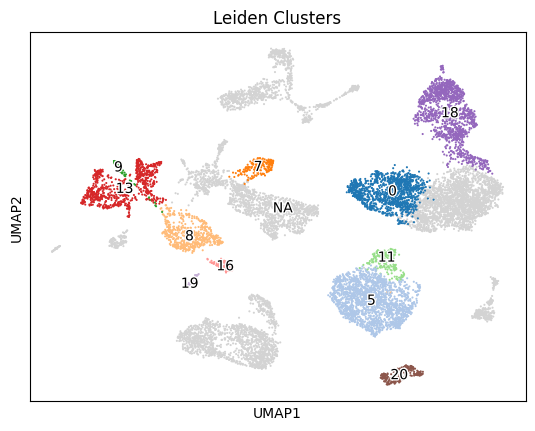

In [112]:
plot_highlighted_umap(adata_copy, 'leiden_clusters', leiden_dpa_targets, 'Leiden Clusters')


### 2.1.e Shared leiden developmental stage st40 and day 0

In [113]:
leiden_day0_st40 = []
for stak in st40_control_clusters:
    # print(f'--- {stak}')
    if stak in leiden_dpa_targets:
        leiden_day0_st40.append(
            (
                leiden_dpa_targets.index(stak) + st40_control_clusters.index(stak),
                stak
                )
            )
print(leiden_day0_st40)

[(0, '20'), (9, '18'), (10, '11'), (15, '8')]


-> Generating UMAP for leiden_clusters...


/tmp/ipython-input-3148644050.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  COLOR_PALETTE = plt.cm.get_cmap('tab20').colors


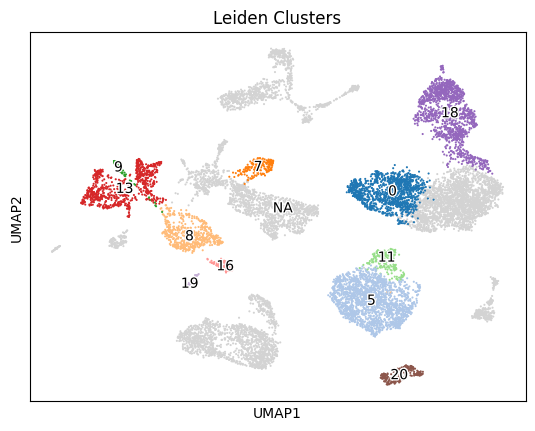

/tmp/ipython-input-3148644050.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  COLOR_PALETTE = plt.cm.get_cmap('tab20').colors


-> Generating UMAP for leiden_clusters...


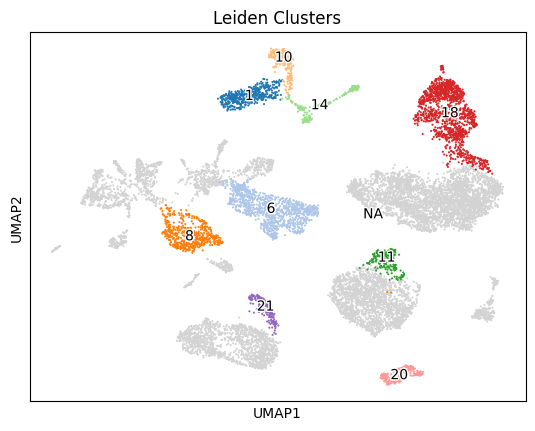

/tmp/ipython-input-3148644050.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  COLOR_PALETTE = plt.cm.get_cmap('tab20').colors


-> Generating UMAP for leiden_clusters...


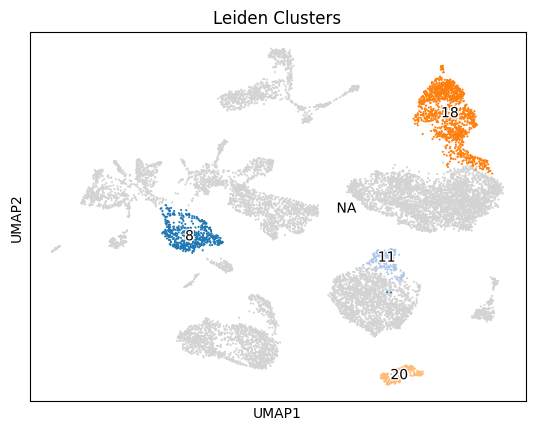

In [114]:
plot_highlighted_umap(adata_copy, 'leiden_clusters', leiden_dpa_targets, 'Leiden Clusters')

plot_highlighted_umap(adata_copy, 'leiden_clusters', st40_control_clusters, 'Leiden Clusters')

plot_highlighted_umap(adata_copy, 'leiden_clusters', [y for x,y in leiden_day0_st40], 'Leiden Clusters')


#### Final Check: Quiescent (G1) Enrichment Test

In [115]:
leiden_d_s = [y for x,y in leiden_day0_st40]

In [116]:
# Define the non-proliferative (quiescent) phase
QUIESCENT_PHASE = ['G1']
CLUSTER_KEY = 'leiden_clusters'

print("--- Checking Quiescent (G1) Enrichment for ROC Candidates ---")

# 1. Create a binary column for Quiescent vs. Non-Quiescent cells
adata_copy.obs['Is_Quiescent'] = adata_copy.obs['CellCyclePhase'].astype(str).apply(
    lambda x: 'Quiescent_G1' if x in QUIESCENT_PHASE else 'Other_Phase'
).astype('category')

# 2. Create the Contingency Table
contingency_table = pd.crosstab(
    index=adata_copy.obs[CLUSTER_KEY],
    columns=adata_copy.obs['Is_Quiescent'],
    normalize=False
)

# 3. Prepare Test Inputs (similar to previous code, focusing on Quiescent_G1 column)
total_quiescent = contingency_table['Quiescent_G1'].sum()
total_other_phase = contingency_table['Other_Phase'].sum()
results = {}
p_values = []
TARGET_CLUSTERS = leiden_d_s

print("-> Running Fisher's Exact Test for Quiescent (G1) Enrichment...")

for cluster_id in contingency_table.index:
    n_cluster_quiescent = contingency_table.loc[cluster_id, 'Quiescent_G1']
    n_cluster_other = contingency_table.loc[cluster_id, 'Other_Phase']

    n_other_quiescent = total_quiescent - n_cluster_quiescent
    n_other_other = total_other_phase - n_cluster_other

    table = [
        [n_cluster_quiescent, n_cluster_other],
        [n_other_quiescent, n_other_other]
    ]

    or_val, p_val = fisher_exact(table, alternative='greater')
    p_values.append(p_val)

    results[cluster_id] = {
        'N_Quiescent_G1': n_cluster_quiescent,
        'N_Other_Phase': n_cluster_other,
        'OR_Quiescent_v_Other': or_val,
    }

# 4. Post-processing and Filtering
enrichment_df = pd.DataFrame.from_dict(results, orient='index')

_, fdr_pvalues, _, _ = multipletests(p_values, method='fdr_bh')
enrichment_df['FDR_Quiescent_Enriched'] = fdr_pvalues

SIGNIFICANCE_THRESHOLD = 0.05
enrichment_df['Is_Quiescent_ROC'] = (
    (enrichment_df['FDR_Quiescent_Enriched'] < SIGNIFICANCE_THRESHOLD) &
    (enrichment_df['OR_Quiescent_v_Other'] > 1)
)

final_df = enrichment_df.loc[TARGET_CLUSTERS].sort_values(
    by='OR_Quiescent_v_Other', ascending=False
)

print("\n--- Quiescent (G1) Enrichment for ROC Candidates ---")
print(final_df[['N_Quiescent_G1', 'N_Other_Phase', 'OR_Quiescent_v_Other', 'FDR_Quiescent_Enriched', 'Is_Quiescent_ROC']])

most_quiescent_cluster = final_df.index[0]
print(f"\n✅ The most quiescent candidate cluster (highest OR) is: {most_quiescent_cluster}")

--- Checking Quiescent (G1) Enrichment for ROC Candidates ---
-> Running Fisher's Exact Test for Quiescent (G1) Enrichment...

--- Quiescent (G1) Enrichment for ROC Candidates ---
    N_Quiescent_G1  N_Other_Phase  OR_Quiescent_v_Other  \
11             173             35              1.71e+00   
18             781            513              4.80e-01   
20              84            132              2.11e-01   
8              134            411              9.94e-02   

    FDR_Quiescent_Enriched  Is_Quiescent_ROC  
11                3.13e-03              True  
18                1.00e+00             False  
20                1.00e+00             False  
8                 1.00e+00             False  

✅ The most quiescent candidate cluster (highest OR) is: 11


### 2.1.f Marker genes of the cluster

In [117]:
# Define the target ROC cluster
TARGET_ROC_CLUSTER = most_quiescent_cluster
GROUPBY_KEY = 'leiden_clusters'

print(f"--- Running DE for ROC Cluster {TARGET_ROC_CLUSTER} vs. All Other Cells ---")

# Method 1: Wilcoxon Rank-Sum Test (Non-parametric, robust for scRNA-seq)
print("-> Method 1: Wilcoxon Rank-Sum Test...")
sc.tl.rank_genes_groups(
    adata_copy,
    groupby=GROUPBY_KEY,
    groups=[TARGET_ROC_CLUSTER],  # Specify the cluster to test
    reference='rest',            # Compare against all other cells/clusters
    method='wilcoxon',
    key_added='roc_wilcoxon_genes'
)

# Method 2: T-test (Parametric)
print("-> Method 2: T-test...")
sc.tl.rank_genes_groups(
    adata_copy,
    groupby=GROUPBY_KEY,
    groups=[TARGET_ROC_CLUSTER],
    reference='rest',
    method='t-test',
    key_added='roc_ttest_genes'
)

top_roc_wilcoxon = (get_top_markers(adata_copy,'roc_wilcoxon_genes', group_id=TARGET_ROC_CLUSTER, n_genes=40))
top_roc_ttest = (get_top_markers(adata_copy,'roc_ttest_genes', group_id=TARGET_ROC_CLUSTER, n_genes=40))
print(top_roc_wilcoxon)
print(top_roc_ttest)

--- Running DE for ROC Cluster 11 vs. All Other Cells ---
-> Method 1: Wilcoxon Rank-Sum Test...
-> Method 2: T-test...
['loc100486548.L', 'mdk.L', 'fn1.S', 'apoc1.like.L', 'lama5.L', 'col14a1.S', 'fras1.L', 'frem2.1.L', 'bambi.L', 'id3.S', 'col14a1.L', 'myh9.S', 'plk2.S', 'egfl6.S', 'id3.L', 'krt5.7.S', 'azin2.S', 'lama1.L', 'nid2.L', 'fstl1.L', 'frem2.L', 'krt18.L', 'msx2.L', 'mdk.S', 'cpamd8.L', 'krt8.L', 'sparc.L', 'mmp3.L', 'pltp.S', 'sparc.S', 'cldn6.2.S', 'Xetrov90029035m.L', 'lamc1.L', 'igfbp2.S', 'bambi.S', 'lamc1.S', 'optc.S', 'epcam.L', 'vwa2.S', 'bcam.L']
['sparc.S', 'mdk.L', 'epcam.S', 'mdk.S', 'epcam.L', 'krt5.7.S', 'tmsb4x.L', 'sparc.L', 's100a11.L', 'loc100486548.L', 'fn1.S', 'id3.S', 'id3.L', 'azin2.S', 'col14a1.S', 'myh9.S', 'apoc1.like.L', 'lama5.L', 'fras1.L', 'ly6g6c.L', 'col14a1.L', 'pfn1.S', 'bambi.L', 'Xelaev18047430m.g', 'myl6.S', 'frem2.1.L', 'Xelaev18043710m.g', 'Xelaev18045052m.g', 'egfl6.S', 'krt12.L', 'plk2.S', 'actg1.S', 'fstl1.L', 'msx2.L', 'frem2.L', 'p

### 2.1.g Compare between 11 and 5
Here i am assuming that 5 are normal skin cells and we want to see what makes 11 different from the cells in 5. Since louvain clustered them together so they must be similiar and i know they share a lot of genes already from failed ideas.

In [118]:
# Define the two clusters for comparison
TARGET_CLUSTER = most_quiescent_cluster
REFERENCE_CLUSTER = '5'
GROUPBY_KEY = 'leiden_clusters'

print(f"--- Running DE for Cluster {TARGET_CLUSTER} vs. Cluster {REFERENCE_CLUSTER} ---")

# Method 1: Wilcoxon Rank-Sum Test (Non-parametric)
print("-> Method 1: Wilcoxon Rank-Sum Test...")
sc.tl.rank_genes_groups(
    adata_copy,
    groupby=GROUPBY_KEY,
    groups=[TARGET_CLUSTER],     # Genes upregulated in the target cluster
    reference=REFERENCE_CLUSTER,  # Compared only against the reference cluster
    method='wilcoxon',
    key_added='wilcoxon_11_vs_5'
)

# Method 2: T-test (Parametric)
print("-> Method 2: T-test...")
sc.tl.rank_genes_groups(
    adata_copy,
    groupby=GROUPBY_KEY,
    groups=[TARGET_CLUSTER],
    reference=REFERENCE_CLUSTER,
    method='t-test',
    key_added='ttest_11_vs_5'
)

# --- Extract and Display Results ---

# Extract the results into a readable DataFrame
wilcoxon_results_df = sc.get.rank_genes_groups_df(
    adata_copy,
    key='wilcoxon_11_vs_5',
    group=TARGET_CLUSTER
)

# Filter for the top 10 genes that are UP-REGULATED in Cluster 11 (positive log-fold change)
top_genes_11_vs_5 = wilcoxon_results_df[
    (wilcoxon_results_df['pvals_adj'] < 0.05) &
    (wilcoxon_results_df['logfoldchanges'] > 0)
].head(10)

print(f"\nTop 10 Genes UPREGULATED in Cluster {TARGET_CLUSTER} compared to Cluster {REFERENCE_CLUSTER} (Wilcoxon):")
print(top_genes_11_vs_5[['names', 'scores', 'pvals_adj', 'logfoldchanges']])

--- Running DE for Cluster 11 vs. Cluster 5 ---
-> Method 1: Wilcoxon Rank-Sum Test...
-> Method 2: T-test...

Top 10 Genes UPREGULATED in Cluster 11 compared to Cluster 5 (Wilcoxon):
            names   scores  pvals_adj  logfoldchanges
0           fn1.S 2.22e+01  3.54e-105        6.14e+00
1  loc100486548.L 1.92e+01   1.41e-78        3.04e+00
2       frem2.1.L 1.90e+01   5.67e-77        4.40e+00
3         bambi.L 1.87e+01   7.98e-75        3.84e+00
4          nid2.L 1.87e+01   9.03e-75        5.93e+00
5         lama1.L 1.86e+01   2.58e-74        4.99e+00
6          krt8.L 1.84e+01   1.79e-72        5.15e+00
7         fstl1.L 1.80e+01   1.72e-69        3.33e+00
8         krt18.L 1.77e+01   4.47e-67        4.69e+00
9         fras1.L 1.72e+01   2.43e-63        2.40e+00


In [119]:
print(adata_copy.obs.head())


        barcode_cells                cell  sample DevelopmentalStage  \
0  AAACCTGAGCTAGTTC.1  AAACCTGAGCTAGTTC.1  SIGAB5               st40   
1  AAACCTGGTGGGTCAA.1  AAACCTGGTGGGTCAA.1  SIGAB5               st40   
2  AAACCTGGTTTGTTGG.1  AAACCTGGTTTGTTGG.1  SIGAB5               st40   
3  AAACGGGGTCGGCATC.1  AAACGGGGTCGGCATC.1  SIGAB5               st40   
4  AAACGGGTCCTACAGA.1  AAACGGGTCCTACAGA.1  SIGAB5               st40   

   DaysPostAmputation        cluster         X         Y CellCyclePhase  \
0                   3  Erythrocyte 4 -6.40e+00  8.32e-01            G2M   
1                   3      Myeloid 1 -2.43e+00  1.38e+01             G1   
2                   3  Beta ionocyte -1.40e+00 -1.47e+01             G1   
3                   3  Erythrocyte 4 -5.86e+00  4.90e-01            G2M   
4                   3    Goblet cell  2.11e+00 -6.59e+00             G1   

   Sample       Lane Condition  batch  n_genes  doublet_score  \
0  SIGAB5  SLX-15583    ST40_3      3     2133     

**Compare the identified markers across different methods.**

In [120]:
def shared(x,y):
  def simple_gtm(s):
    return get_top_markers(adata_copy,s, group_id=TARGET_ROC_CLUSTER, n_genes=10)
  return list(
      (
          set(
              x if isinstance(x,list) else simple_gtm(x)
              )
          ).intersection(
              (
                  set(
                      y if isinstance(y,list) else simple_gtm(y)
                      )
                  )
              )
          )


shared_markers_11v5 = shared('wilcoxon_11_vs_5','ttest_11_vs_5')
shared_markers_roc = shared('roc_wilcoxon_genes','roc_ttest_genes')
shared_markers = shared(shared_markers_11v5,shared_markers_roc)
print(shared_markers_11v5)
print(shared_markers_roc)
print('shared markers\n')
for stak in shared_markers:
  print(f'marker:{stak}')

['frem2.1.L', 'bambi.L', 'fstl1.L', 'krt8.L', 'nid2.L', 'fras1.L', 'loc100486548.L', 'krt18.L', 'lama1.L', 'fn1.S']
['mdk.L', 'loc100486548.L']
shared markers

marker:loc100486548.L


## 2.3 Validate against table 3

https://docs.google.com/spreadsheets/d/11YqwlmXqgMFcWGum9Dbr5oDi1RWCdX8W/edit?usp=sharing&ouid=113999859350074512030&rtpof=true&sd=true

In [121]:

# 1. Define the Google Sheet ID
sheet_id = '11YqwlmXqgMFcWGum9Dbr5oDi1RWCdX8W'

# 2. Construct the direct export link
export_url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx'

# 3. Read the file directly from the URL into a DataFrame
# Note: You may need to install the 'openpyxl' engine if you haven't already: !pip install openpyxl
df_gene_map = pd.read_excel(export_url, sheet_name=None)

ROC_markers = df_gene_map['ROC markers']

top_11v5_w = get_top_markers(adata_copy, 'wilcoxon_11_vs_5')
top_11v5_t = get_top_markers(adata_copy, 'ttest_11_vs_5')
# 'wilcoxon_11_vs_5','ttest_11_vs_5'
table3_genes_found = []
def remove_dot(_list):
  return set([x.split('.')[0] for x in _list])
filtered = remove_dot(shared_markers)
# p
for index, row in ROC_markers.iterrows():
  value = row.values[0]
  if (value in remove_dot(top_roc_wilcoxon)) or (value in remove_dot(top_roc_ttest)) or (value in remove_dot(top_11v5_w)) or(value in remove_dot(top_11v5_t)):
    print(value)
    table3_genes_found.append(value)

egfl6
nid2
igfbp2
frem2
pltp


### shared genes


**Printing out known values**

In [122]:
ROC_markers = df_gene_map['ROC markers']
print(f'found {len(table3_genes_found)} out of {len(ROC_markers.iloc[:,0])} in table 3')
print(f'Percentage {100*len(table3_genes_found)/len(ROC_markers.iloc[:,0]):.2f}%')


found 5 out of 49 in table 3
Percentage 10.20%


## 2.6 Go Analysis

No significant overlap found in key developmental pathways.
No significant overlap found in key developmental pathways.


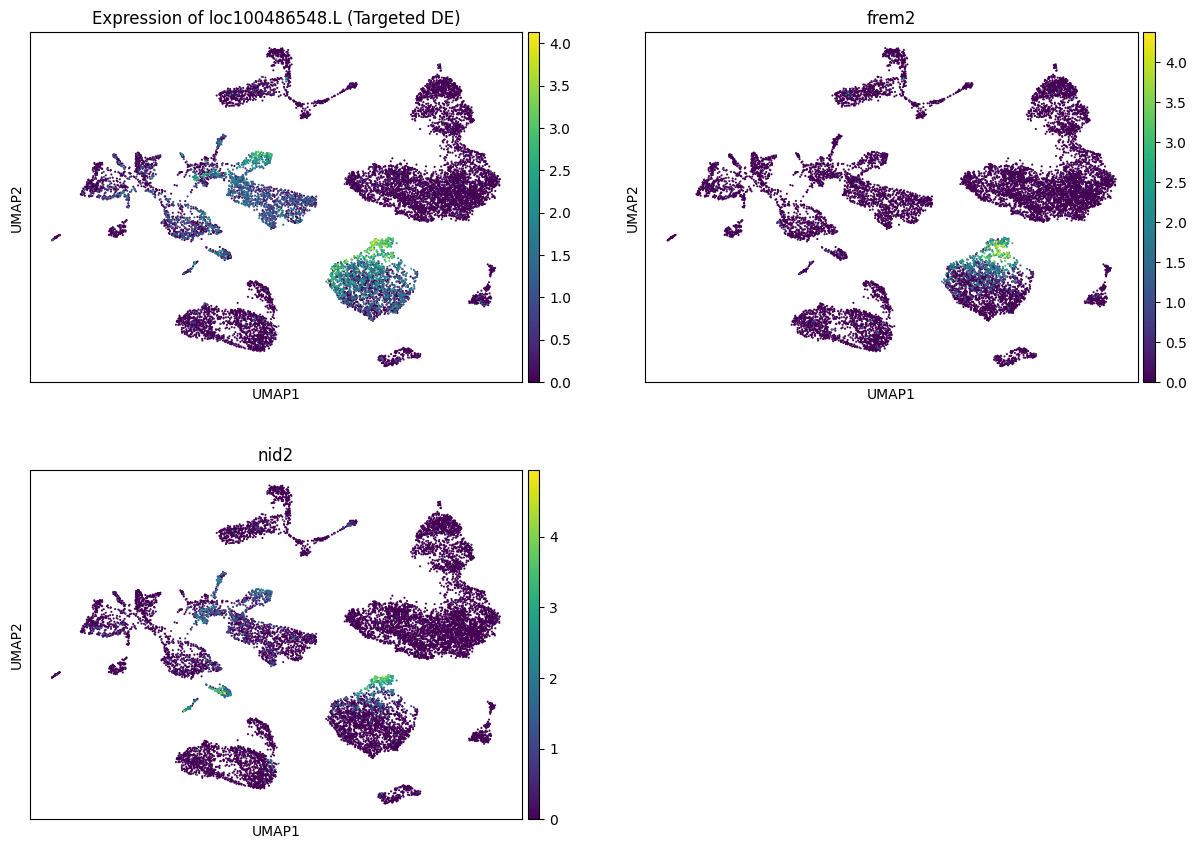

In [123]:
def perform_go_analysis(gene_list):
    """
    Simulates Gene Ontology enrichment analysis by checking common developmental pathways
    against the provided Supplementary Tables.
    """
    go_results = {}

    # Files provided in the upload that represent GO-like pathways
    ligand_files = {
        'FGF ligands (Development/Regeneration)': "aav9996_tables3.xlsx - FGF ligands.csv",
        'WNT ligands (Development/Regeneration)': "aav9996_tables3.xlsx - WNT ligands.csv",
        'BMP ligands (Development/Regeneration)': "aav9996_tables3.xlsx - BMP ligands.csv",
        'NOTCH receptors (Signaling)': "aav9996_tables3.xlsx - NOTCH receptors.csv",
    }
    fgf = df_gene_map['FGF ligands'].iloc[:,0]
    wnt = df_gene_map['WNT ligands'].iloc[:,0]
    bmp = df_gene_map['BMP ligands'].iloc[:,0]
    for known_pathway_genes in [fgf,wnt,bmp]:
        overlap = set(gene_list).intersection(known_pathway_genes)
        if overlap:
            # Fisher's exact test to simulate enrichment odds (Optional Bonus Metric)
            # a: genes in list AND pathway (overlap)
            # b: genes in list AND NOT in pathway (list_size - overlap)
            # c: genes NOT in list AND in pathway (pathway_size - overlap)
            # d: genes NOT in list AND NOT in pathway (total_genes - list_size - pathway_size + overlap)

            list_size = len(gene_list)
            pathway_size = len(known_pathway_genes)
            total_genes = 31535  # Approximate n_vars from loaded data

            a = len(overlap)
            b = list_size - a
            c = pathway_size - a
            d = total_genes - list_size - pathway_size + a

            # Perform Fisher's Exact Test
            odds_ratio, p_value = fisher_exact([[a, b], [c, d]])

            go_results[pathway] = {
                'Matches': list(overlap),
                'Odds Ratio': f"{odds_ratio:.2f}",
                'p-value': f"{p_value:.2e}",
                'Annotation': f"Strong Overlap (Odds Ratio: {odds_ratio:.2f})"
            }

    return go_results


go_results = perform_go_analysis(shared_markers_11v5)
if go_results:
    for pathway, result in go_results.items():
        print(f"\nPathway: {pathway}")
        print(f"  Matches: {result['Matches']}")
        print(f"  Odds Ratio: {result['Odds Ratio']}")
        print(f"  p-value: {result['p-value']}")
        print(f"  Annotation: {result['Annotation']}")
else:
    print("No significant overlap found in key developmental pathways.")
go_results = perform_go_analysis(filtered)
if go_results:
    for pathway, result in go_results.items():
        print(f"\nPathway: {pathway}")
        print(f"  Matches: {result['Matches']}")
        print(f"  Odds Ratio: {result['Odds Ratio']}")
        print(f"  p-value: {result['p-value']}")
        print(f"  Annotation: {result['Annotation']}")
else:
    print("No significant overlap found in key developmental pathways.")



sc.pl.umap(adata_copy,
            color=[top_roc_wilcoxon[0],'frem2.1.L', 'nid2.L',],
            title=[f"Expression of {top_roc_wilcoxon[0]} (Targeted DE)", f"frem2",f"nid2"],
            ncols=2,
            show=True)

# 3 Data Denoising:

Use at least two of the techniques presented in  [2] and evaluate the impact it has on Clustering Analysis (1) and Marker Selection (2)

Main Paper: [2]  https://www.nature.com/articles/s41587-025-02694-w

## 3.0 Pipeline Function

In [124]:
def run_pipeline_and_evaluate(adata0, run_name, batch_key=None, regress_out_key=None):
    """Runs PCA, Neighbors, Clustering, and calculates metrics on the given AnnData object."""
    adata2 = adata.copy()
        # 2. Feature Selection (HVG) - Moved to the beginning
    print("-> Identifying highly variable genes...")
    sc.pp.filter_cells(adata, min_genes=100)
    sc.pp.filter_genes(adata, min_cells=10)
    # This must run before regression to establish the working subset
    sc.pp.normalize_total(adata2) # Normalizing to median total counts - scanpy docs
    sc.pp.log1p(adata2) # Logarithmize the data - scanpy docs
    sc.pp.highly_variable_genes(adata2, n_top_genes=2000, batch_key=batch_key)

    # CRUCIAL STEP: Restrict to HVGs for faster regression
    # This creates the *working subset* for the rest of the pipeline

    adata2 = adata2[:, adata2.var.highly_variable].copy()
    print(f"-> Working with {adata2.n_vars} highly variable genes.")

    # 1. Apply regression for denoising or batch integration (Technique)
    if regress_out_key:
        # Scale only the HVG subset
        sc.pp.scale(adata2, max_value=10)

        print(f"-> Denoising: Regressing out {regress_out_key}...")
        # Regression is now much faster on the subset
        sc.pp.regress_out(adata2, regress_out_key)
    # 1. Apply regression for denoising or batch integration (Technique)
        if not isinstance(adata2.X, np.ndarray):
            adata2.X = adata2.X.toarray()
        print("-> Scaling data after regression...")
        # sc.pp.scale(adata2, max_value=10)
        adata2.X = np.nan_to_num(
            adata2.X,
            nan=0.0,
            posinf=np.finfo(float).max,
            neginf=np.finfo(float).min
        )
        # Scale data after regression to prevent issues with large values
        # print("-> Scaling data after regression...")
        # sc.pp.scale(adata2, max_value=10)
    # 3. PCA
    print("-> Running PCA...")
    sc.pp.pca(adata2, n_comps=50)

    # 4. Nearest Neighbors
    print("-> Computing neighbors graph...")
    sc.pp.neighbors(adata2)

    # 5. Clustering (Leiden)
    print("-> Running Leiden clustering...")
    cluster_key = f'leiden_{run_name}'
    sc.tl.leiden(adata2, key_added=cluster_key, resolution=0.4) # Using leiden as it performed slightly better
    print(f"-> Columns in adata2.obs after clustering: {adata2.obs.columns.tolist()}") # Add print statement


    # --- Evaluation ---
    # Evaluate against original cluster annotation (assuming 'cluster' in adata.obs is the known truth)
    labels_known = adata.obs['cluster'].astype(str) # Use the original adata for known labels
    labels_clustered = adata2.obs[cluster_key].astype(str)

    # Ensure the order of cells is the same before calculating metrics
    labels_known = labels_known[adata2.obs_names]

    print("-> Calculating clustering metrics...")
    # Adjusted Rand Index (ARI)
    ari = metrics.adjusted_rand_score(labels_known, labels_clustered)

    # Silhouette Score (Internal Metric)
    # Use the PCA embedding from the *processed* adata2 object
    silhouette = metrics.silhouette_score(adata2.obsm['X_pca'], labels_clustered, metric='euclidean')

    # Store clustering results in adata_copy for later visualization/analysis
    # This might not be needed if we return adata2 and use it directly
    # adata_copy.obs[f'leiden_{run_name}'] = adata2.obs[f'leiden_{run_name}']


    return adata2, ari, silhouette # Return the processed adata object

## 3.1 First denoise and integrate

In [125]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print("\n--- Denoising and Batch Integration ---")

    # Store original clustering metrics for comparison
    original_ari = metrics.adjusted_rand_score(adata_copy.obs['cluster'].astype(str), adata_copy.obs['leiden_clusters'].astype(str))
    original_silhouette = metrics.silhouette_score(adata_copy.obsm['X_pca'], adata_copy.obs['leiden_clusters'].astype(str), metric='euclidean')

    print(f"\nOriginal Clustering Metrics (Leiden on uncorrected data):")
    print(f"   ARI: {original_ari:.4f}, Silhouette: {original_silhouette:.4f}")


    # --- TECHNIQUE 1: DENOISING (Regress out Cell Cycle Effect) ---
    # Technique: Explicitly removing the variance contributed by cell cycle genes.
    print("\n2. Denoising (Regressing out CellCyclePhase):")

    # Pass adata_copy which has normalized and log1p data
    adata_denoise, ari_denoised, silhouette_denoised = run_pipeline_and_evaluate(
        adata_copy,
        run_name='denoised_cc',
        regress_out_key='CellCyclePhase'
    )
    print(f"   Denoised (CellCyclePhase) ARI: {ari_denoised:.4f}, Silhouette: {silhouette_denoised:.4f}")

    # --- TECHNIQUE 2: BATCH INTEGRATION (Regress out Batch Effect) ---
    # Technique: Explicit Batch Integration to remove batch-specific technical noise.
    print("\n3. Batch Integration (Regressing out Batch):")

    # Pass adata_copy which has normalized and log1p data
    adata_integ, ari_integrated, silhouette_integrated = run_pipeline_and_evaluate(
        adata_copy,
        run_name='integrated_batch',
        regress_out_key='batch'
    )
    print(f"   Denoised (CellCyclePhase) ARI: {ari_integrated:.4f}, Silhouette: {silhouette_integrated:.4f}")

    sc.pp.filter_genes(adata_denoise, min_cells=1)
    sc.pp.filter_genes(adata_integ, min_cells=1)
    print("\n--- Denoising and Batch Integration Evaluation Complete ---")


--- Denoising and Batch Integration ---

Original Clustering Metrics (Leiden on uncorrected data):
   ARI: 0.5817, Silhouette: 0.3303

2. Denoising (Regressing out CellCyclePhase):
-> Identifying highly variable genes...
-> Working with 2000 highly variable genes.
-> Denoising: Regressing out CellCyclePhase...
-> Scaling data after regression...
-> Running PCA...
-> Computing neighbors graph...
-> Running Leiden clustering...
-> Columns in adata2.obs after clustering: ['barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden_denoised_cc']
-> Calculating clustering metrics...
   Denoised (CellCyclePhase) ARI: 0.6849, Silhouette: 0.3112

3. Batch Integration (Regressing out Batch):
-> Identifying highly variable genes...
-> Working with 2000 highly variable genes.
-> Denoising: Regressing out batch...
-> Scaling data after regressi

**Check AnnData Object Columns**

verifying integrity of previous alterations

In [126]:
print("\n--- Checking Columns in Denoised and Integrated AnnData Objects ---")

if 'adata_denoise' in locals():
    print(f"Columns in adata_denoise.obs: {adata_denoise.obs.columns.tolist()}")
    print(f"Columns in adata_integ.obs: {adata_integ.obs.columns.tolist()}")


--- Checking Columns in Denoised and Integrated AnnData Objects ---
Columns in adata_denoise.obs: ['barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden_denoised_cc']
Columns in adata_integ.obs: ['barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden_integrated_batch']


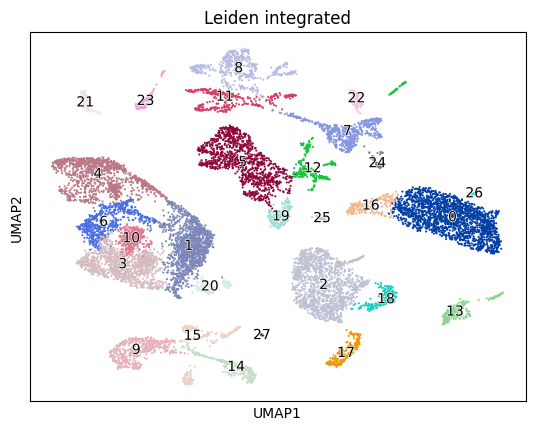

In [127]:
sc.tl.umap(adata_integ)
sc.pl.umap(adata_integ,
            color=['leiden_integrated_batch'],
            title=[f"Leiden integrated"],
               legend_loc="on data",
    legend_fontoutline=1,
    legend_fontweight="normal",
            ncols=2,
            show=True)

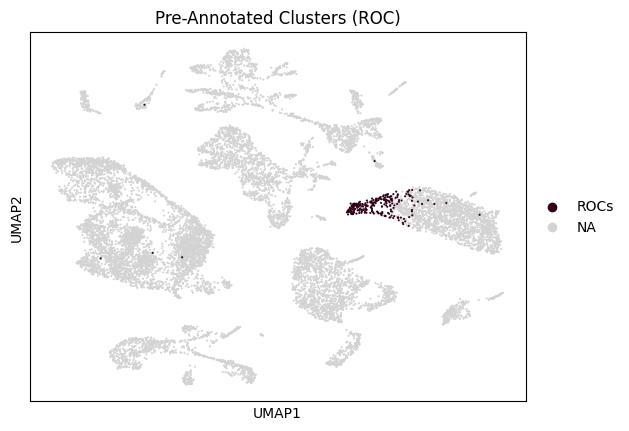

In [128]:
sc.pl.umap(adata_integ,
                color=['cluster'],
                title=['Pre-Annotated Clusters (ROC)'],
                show=True,
           groups=['ROCs'],
          #  legend_loc="on data",
           legend_fontoutline=1,
           legend_fontweight="normal",
            ncols=1
          #  palette=3*['tab20']
            # Explicitly provide palette names instead of None for the first two plots
            # palette=['viridis', 'plasma', cluster_colors]
           )

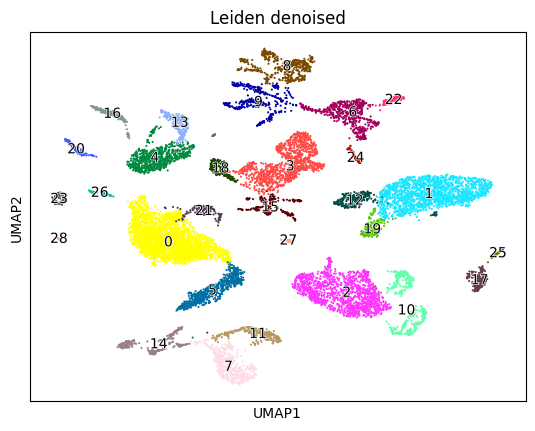

In [129]:
sc.tl.umap(adata_denoise)
sc.pl.umap(adata_denoise,
            color=['leiden_denoised_cc'],
            title=[f"Leiden denoised"],
               legend_loc="on data",
    legend_fontoutline=1,
    legend_fontweight="normal",
            ncols=2,
            show=True)

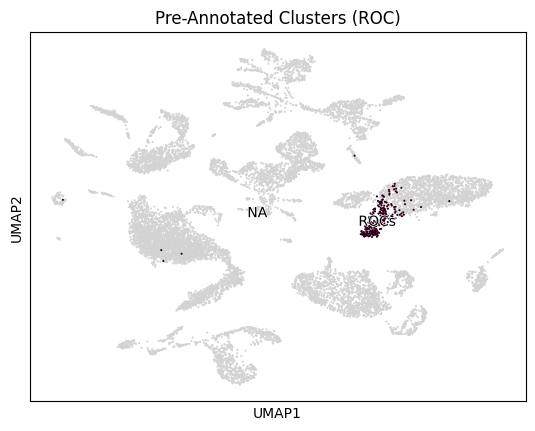

In [130]:
sc.pl.umap(adata_denoise,
                color=['cluster'],
                title=['Pre-Annotated Clusters (ROC)'],
                show=True,
           groups=['ROCs'],
           legend_loc="on data",
           legend_fontoutline=1,
           legend_fontweight="normal",
            ncols=1

           )

### 3.1.a Find clusters after denoising and integrated batching



We need to perform the same steps as earlier which we used to find our new cluster 11 equivalent.

#### Denoised

##### Denoised day 0 after amputation

In [131]:
# --- 1. Data Preparation ---
target_day = '0' # Use string representation matching your metadata
print(f"-> Creating Contingency Table for DPA {target_day} vs. All Other Cells...")

# Create a binary column for the comparison
# Assuming 'leiden_clusters' and 'DaysPostAmputation' are in adata_copy.obs
adata_denoise.obs['Is_DPA2'] = adata_denoise.obs['DaysPostAmputation'].astype(str).apply(
    lambda x: f'DPA_{target_day}' if x == target_day else 'Other_DPA'
)

# Contingency table: Clusters (Rows) vs. DPA_2 (Columns)
contingency_table = pd.crosstab(
    index=adata_denoise.obs['leiden_denoised_cc'],
    columns=adata_denoise.obs['Is_DPA2'],
    normalize=False
)

# Handle cases where the target column might be missing if no cells are DPA 2
target_col = f'DPA_{target_day}'
if target_col not in contingency_table.columns:
    print(f"❌ WARNING: No cells found with DaysPostAmputation = {target_day}. All clusters will show no enrichment.")
    # Pad the table to prevent errors in the loop
    contingency_table[target_col] = 0

# --- 2. Calculate Totals and Initialize Results ---
total_target = contingency_table[target_col].sum()
total_other = contingency_table['Other_DPA'].sum()
results = {}

# --- 3. Perform Fisher's Exact Test for Each Cluster ---
print(f"-> Running Fisher's Exact Test for enrichment in DPA {target_day}...")
p_values = []

for cluster_id in contingency_table.index:
    n_cluster_target = contingency_table.loc[cluster_id, target_col]
    n_cluster_other = contingency_table.loc[cluster_id, 'Other_DPA']

    n_other_target = total_target - n_cluster_target
    n_other_other = total_other - n_cluster_other

    # 2x2 table: [[Cluster N_target, Cluster N_other], [Other N_target, Other N_other]]
    table = [
        [n_cluster_target, n_cluster_other],
        [n_other_target, n_other_other]
    ]

    # Test for enrichment in the target DPA
    or_val, p_val = fisher_exact(table, alternative='greater')
    p_values.append(p_val)

    results[cluster_id] = {
        f'N_DPA_{target_day}': n_cluster_target,
        'N_Other': n_cluster_other,
        f'OR_DPA_{target_day}_v_Other': or_val,
    }

# Convert results to DataFrame
enrichment_df = pd.DataFrame.from_dict(results, orient='index')

# --- 4. Apply FDR Correction (Benjamini-Hochberg) ---
print("-> Applying FDR Correction...")
_, fdr_pvalues, _, _ = multipletests(p_values, method='fdr_bh')
enrichment_df['FDR_DPA_Enriched'] = fdr_pvalues

# --- 5. Determine Significance and Display Results ---
SIGNIFICANCE_THRESHOLD = 0.01
enrichment_df[f'DPA_{target_day}_Characteristic'] = (
    (enrichment_df['FDR_DPA_Enriched'] < SIGNIFICANCE_THRESHOLD) &
    (enrichment_df[f'OR_DPA_{target_day}_v_Other'] > 1)
)

pd.set_option('display.float_format', '{:.2e}'.format)
enrichment_df = enrichment_df.sort_values(by=f'OR_DPA_{target_day}_v_Other', ascending=False)

print(f"\n--- Leiden Cluster Enrichment Analysis: DPA {target_day} vs. All Other Cells ---")
print(enrichment_df[[f'N_DPA_{target_day}', 'N_Other', f'OR_DPA_{target_day}_v_Other', 'FDR_DPA_Enriched', f'DPA_{target_day}_Characteristic']])

leiden_dpa_denoised = enrichment_df[enrichment_df[f'DPA_{target_day}_Characteristic']].index.tolist()
print(f"\n✅ Clusters Statistically Enriched in DPA {target_day}: {leiden_dpa_denoised}")

-> Creating Contingency Table for DPA 0 vs. All Other Cells...
-> Running Fisher's Exact Test for enrichment in DPA 0...
-> Applying FDR Correction...

--- Leiden Cluster Enrichment Analysis: DPA 0 vs. All Other Cells ---
    N_DPA_0  N_Other  OR_DPA_0_v_Other  FDR_DPA_Enriched  DPA_0_Characteristic
24       56        3          2.84e+01          2.10e-18                  True
16      192       19          1.57e+01          4.23e-54                  True
19      116       36          4.94e+00          4.62e-19                  True
22       73       31          3.58e+00          1.46e-09                  True
26       26       16          2.45e+00          6.71e-03                  True
18      105       71          2.25e+00          2.39e-07                  True
5       380      294          2.02e+00          3.78e-18                  True
6       311      241          2.00e+00          6.61e-15                  True
13      131      106          1.88e+00          2.76e-06           

##### Quiescent

In [132]:
# Define the non-proliferative (quiescent) phase
QUIESCENT_PHASE = ['G1']
CLUSTER_KEY = 'leiden_denoised_cc'

print("--- Checking Quiescent (G1) Enrichment for ROC Candidates ---")

# 1. Create a binary column for Quiescent vs. Non-Quiescent cells
adata_denoise.obs['Is_Quiescent'] = adata_denoise.obs['CellCyclePhase'].astype(str).apply(
    lambda x: 'Quiescent_G1' if x in QUIESCENT_PHASE else 'Other_Phase'
).astype('category')

# 2. Create the Contingency Table
contingency_table = pd.crosstab(
    index=adata_denoise.obs[CLUSTER_KEY],
    columns=adata_denoise.obs['Is_Quiescent'],
    normalize=False
)

# 3. Prepare Test Inputs (similar to previous code, focusing on Quiescent_G1 column)
total_quiescent = contingency_table['Quiescent_G1'].sum()
total_other_phase = contingency_table['Other_Phase'].sum()
results = {}
p_values = []
TARGET_CLUSTERS = leiden_dpa_denoised

print("-> Running Fisher's Exact Test for Quiescent (G1) Enrichment...")

for cluster_id in contingency_table.index:
    n_cluster_quiescent = contingency_table.loc[cluster_id, 'Quiescent_G1']
    n_cluster_other = contingency_table.loc[cluster_id, 'Other_Phase']

    n_other_quiescent = total_quiescent - n_cluster_quiescent
    n_other_other = total_other_phase - n_cluster_other

    table = [
        [n_cluster_quiescent, n_cluster_other],
        [n_other_quiescent, n_other_other]
    ]

    or_val, p_val = fisher_exact(table, alternative='greater')
    p_values.append(p_val)

    results[cluster_id] = {
        'N_Quiescent_G1': n_cluster_quiescent,
        'N_Other_Phase': n_cluster_other,
        'OR_Quiescent_v_Other': or_val,
    }

# 4. Post-processing and Filtering
enrichment_df = pd.DataFrame.from_dict(results, orient='index')

_, fdr_pvalues, _, _ = multipletests(p_values, method='fdr_bh')
enrichment_df['FDR_Quiescent_Enriched'] = fdr_pvalues

SIGNIFICANCE_THRESHOLD = 0.05
enrichment_df['Is_Quiescent_ROC'] = (
    (enrichment_df['FDR_Quiescent_Enriched'] < SIGNIFICANCE_THRESHOLD) &
    (enrichment_df['OR_Quiescent_v_Other'] > 1)
)

final_df = enrichment_df.loc[TARGET_CLUSTERS].sort_values(
    by='OR_Quiescent_v_Other', ascending=False
)

print("\n--- Quiescent (G1) Enrichment for ROC Candidates ---")
print(final_df[['N_Quiescent_G1', 'N_Other_Phase', 'OR_Quiescent_v_Other', 'FDR_Quiescent_Enriched', 'Is_Quiescent_ROC']])

most_quiescent_cluster = final_df.index[0]
print(f"\n✅ The most quiescent candidate cluster (highest OR) is: {most_quiescent_cluster}")

# 1. Filter the final_df where the characteristic is True
quiescent_denoised_clusters = final_df[final_df['Is_Quiescent_ROC'] == True].index.tolist()

# 2. Print the resulting list
print(f"✅ Quiescent ROC Candidate Clusters (Is_Quiescent_ROC == True): {quiescent_denoised_clusters}")

--- Checking Quiescent (G1) Enrichment for ROC Candidates ---
-> Running Fisher's Exact Test for Quiescent (G1) Enrichment...

--- Quiescent (G1) Enrichment for ROC Candidates ---
    N_Quiescent_G1  N_Other_Phase  OR_Quiescent_v_Other  \
5              674              0                   inf   
0             2794              1              1.34e+03   
8              446              2              8.00e+01   
1             1629             35              1.89e+01   
26              37              5              2.54e+00   
19             132             20              2.28e+00   
18             150             26              1.99e+00   
24              50              9              1.91e+00   
22              66             38              5.92e-01   
10             184            215              2.80e-01   
6              136            416              9.95e-02   
12              12            239              1.60e-02   
13               2            235              2.71e-

##### Decision



In [133]:
denoised_decision = []
quiescent_denoised_clusters
leiden_dpa_denoised
for stak in leiden_dpa_denoised:
  if stak in quiescent_denoised_clusters:
    denoised_decision.append((leiden_dpa_denoised.index(stak)+quiescent_denoised_clusters.index(stak),stak))
print(denoised_decision)

[(7, '19'), (8, '26'), (11, '18'), (6, '5'), (12, '8'), (14, '1'), (14, '0')]


#### Integrated

##### Integrated day 0 after amputation

In [134]:
# --- 1. Data Preparation ---
target_day = '0' # Use string representation matching your metadata
print(f"-> Creating Contingency Table for DPA {target_day} vs. All Other Cells...")

# Create a binary column for the comparison
# Assuming 'leiden_clusters' and 'DaysPostAmputation' are in adata_copy.obs
adata_integ.obs['Is_DPA2'] = adata_integ.obs['DaysPostAmputation'].astype(str).apply(
    lambda x: f'DPA_{target_day}' if x == target_day else 'Other_DPA'
)

# Contingency table: Clusters (Rows) vs. DPA_2 (Columns)
contingency_table = pd.crosstab(
    index=adata_integ.obs['leiden_integrated_batch'],
    columns=adata_integ.obs['Is_DPA2'],
    normalize=False
)

# Handle cases where the target column might be missing if no cells are DPA 2
target_col = f'DPA_{target_day}'
if target_col not in contingency_table.columns:
    print(f"❌ WARNING: No cells found with DaysPostAmputation = {target_day}. All clusters will show no enrichment.")
    # Pad the table to prevent errors in the loop
    contingency_table[target_col] = 0

# --- 2. Calculate Totals and Initialize Results ---
total_target = contingency_table[target_col].sum()
total_other = contingency_table['Other_DPA'].sum()
results = {}

# --- 3. Perform Fisher's Exact Test for Each Cluster ---
print(f"-> Running Fisher's Exact Test for enrichment in DPA {target_day}...")
p_values = []

for cluster_id in contingency_table.index:
    n_cluster_target = contingency_table.loc[cluster_id, target_col]
    n_cluster_other = contingency_table.loc[cluster_id, 'Other_DPA']

    n_other_target = total_target - n_cluster_target
    n_other_other = total_other - n_cluster_other

    # 2x2 table: [[Cluster N_target, Cluster N_other], [Other N_target, Other N_other]]
    table = [
        [n_cluster_target, n_cluster_other],
        [n_other_target, n_other_other]
    ]

    # Test for enrichment in the target DPA
    or_val, p_val = fisher_exact(table, alternative='greater')
    p_values.append(p_val)

    results[cluster_id] = {
        f'N_DPA_{target_day}': n_cluster_target,
        'N_Other': n_cluster_other,
        f'OR_DPA_{target_day}_v_Other': or_val,
    }

# Convert results to DataFrame
enrichment_df = pd.DataFrame.from_dict(results, orient='index')

# --- 4. Apply FDR Correction (Benjamini-Hochberg) ---
print("-> Applying FDR Correction...")
_, fdr_pvalues, _, _ = multipletests(p_values, method='fdr_bh')
enrichment_df['FDR_DPA_Enriched'] = fdr_pvalues

# --- 5. Determine Significance and Display Results ---
SIGNIFICANCE_THRESHOLD = 0.01
enrichment_df[f'DPA_{target_day}_Characteristic'] = (
    (enrichment_df['FDR_DPA_Enriched'] < SIGNIFICANCE_THRESHOLD) &
    (enrichment_df[f'OR_DPA_{target_day}_v_Other'] > 1)
)

pd.set_option('display.float_format', '{:.2e}'.format)
enrichment_df = enrichment_df.sort_values(by=f'OR_DPA_{target_day}_v_Other', ascending=False)

print(f"\n--- Leiden Cluster Enrichment Analysis: DPA {target_day} vs. All Other Cells ---")
print(enrichment_df[[f'N_DPA_{target_day}', 'N_Other', f'OR_DPA_{target_day}_v_Other', 'FDR_DPA_Enriched', f'DPA_{target_day}_Characteristic']])

leiden_dpa_integ = enrichment_df[enrichment_df[f'DPA_{target_day}_Characteristic']].index.tolist()
print(f"\n✅ Clusters Statistically Enriched in DPA {target_day}: {leiden_dpa_integ}")

-> Creating Contingency Table for DPA 0 vs. All Other Cells...
-> Running Fisher's Exact Test for enrichment in DPA 0...
-> Applying FDR Correction...

--- Leiden Cluster Enrichment Analysis: DPA 0 vs. All Other Cells ---
    N_DPA_0  N_Other  OR_DPA_0_v_Other  FDR_DPA_Enriched  DPA_0_Characteristic
17      215        1          3.37e+02          2.32e-84                  True
10      399       16          4.05e+01         2.30e-137                  True
24       56        3          2.84e+01          1.35e-18                  True
22       72       31          3.53e+00          1.76e-09                  True
16      149       69          3.32e+00          4.64e-17                  True
4       699      416          2.76e+00          4.42e-57                  True
1       853      541          2.64e+00          1.51e-63                  True
19      105       71          2.25e+00          2.10e-07                  True
7       313      242          2.01e+00          3.21e-15           

-> Generating UMAP for leiden_integrated_batch...


/tmp/ipython-input-3148644050.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  COLOR_PALETTE = plt.cm.get_cmap('tab20').colors


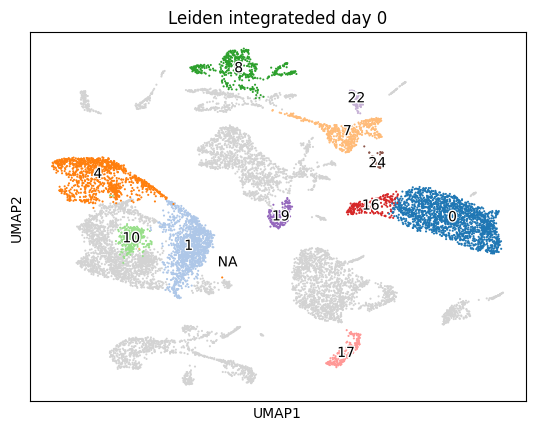

In [135]:
plot_highlighted_umap(adata_integ,'leiden_integrated_batch',leiden_dpa_integ,'Leiden integrateded day 0')

##### Quiescent

In [136]:
# Define the non-proliferative (quiescent) phase
QUIESCENT_PHASE = ['G1']
CLUSTER_KEY = 'leiden_integrated_batch'

print("--- Checking Quiescent (G1) Enrichment for ROC Candidates ---")

# 1. Create a binary column for Quiescent vs. Non-Quiescent cells
adata_integ.obs['Is_Quiescent'] = adata_integ.obs['CellCyclePhase'].astype(str).apply(
    lambda x: 'Quiescent_G1' if x in QUIESCENT_PHASE else 'Other_Phase'
).astype('category')

# 2. Create the Contingency Table
contingency_table = pd.crosstab(
    index=adata_integ.obs[CLUSTER_KEY],
    columns=adata_integ.obs['Is_Quiescent'],
    normalize=False
)

# 3. Prepare Test Inputs (similar to previous code, focusing on Quiescent_G1 column)
total_quiescent = contingency_table['Quiescent_G1'].sum()
total_other_phase = contingency_table['Other_Phase'].sum()
results = {}
p_values = []
TARGET_CLUSTERS = leiden_dpa_integ

print("-> Running Fisher's Exact Test for Quiescent (G1) Enrichment...")

for cluster_id in contingency_table.index:
    n_cluster_quiescent = contingency_table.loc[cluster_id, 'Quiescent_G1']
    n_cluster_other = contingency_table.loc[cluster_id, 'Other_Phase']

    n_other_quiescent = total_quiescent - n_cluster_quiescent
    n_other_other = total_other_phase - n_cluster_other

    table = [
        [n_cluster_quiescent, n_cluster_other],
        [n_other_quiescent, n_other_other]
    ]

    or_val, p_val = fisher_exact(table, alternative='greater')
    p_values.append(p_val)

    results[cluster_id] = {
        'N_Quiescent_G1': n_cluster_quiescent,
        'N_Other_Phase': n_cluster_other,
        'OR_Quiescent_v_Other': or_val,
    }

# 4. Post-processing and Filtering
enrichment_df = pd.DataFrame.from_dict(results, orient='index')

_, fdr_pvalues, _, _ = multipletests(p_values, method='fdr_bh')
enrichment_df['FDR_Quiescent_Enriched'] = fdr_pvalues

SIGNIFICANCE_THRESHOLD = 0.05
enrichment_df['Is_Quiescent_ROC'] = (
    (enrichment_df['FDR_Quiescent_Enriched'] < SIGNIFICANCE_THRESHOLD) &
    (enrichment_df['OR_Quiescent_v_Other'] > 1)
)

final_df = enrichment_df.loc[TARGET_CLUSTERS].sort_values(
    by='OR_Quiescent_v_Other', ascending=False
)

print("\n--- Quiescent (G1) Enrichment for ROC Candidates ---")
print(final_df[['N_Quiescent_G1', 'N_Other_Phase', 'OR_Quiescent_v_Other', 'FDR_Quiescent_Enriched', 'Is_Quiescent_ROC']])

most_quiescent_cluster = final_df.index[0]
print(f"\n✅ The most quiescent candidate cluster (highest OR) is: {most_quiescent_cluster}")

# 1. Filter the final_df where the characteristic is True
quiescent_integrated_clusters = final_df[final_df['Is_Quiescent_ROC'] == True].index.tolist()

# 2. Print the resulting list
print(f"✅ Quiescent ROC Candidate Clusters (Is_Quiescent_ROC == True): {quiescent_integrated_clusters}")

--- Checking Quiescent (G1) Enrichment for ROC Candidates ---
-> Running Fisher's Exact Test for Quiescent (G1) Enrichment...

--- Quiescent (G1) Enrichment for ROC Candidates ---
    N_Quiescent_G1  N_Other_Phase  OR_Quiescent_v_Other  \
8              483              2              8.70e+01   
10             400             15              9.49e+00   
1             1266            128              3.75e+00   
0             1573            260              2.28e+00   
16             188             30              2.17e+00   
19             150             26              1.99e+00   
24              50              9              1.91e+00   
22              66             37              6.09e-01   
4              672            443              4.84e-01   
17              84            132              2.11e-01   
7              138            417              1.01e-01   

    FDR_Quiescent_Enriched  Is_Quiescent_ROC  
8                 7.81e-59              True  
10               

##### Decision

In [137]:
integrated_decision = []
for stak in leiden_dpa_integ:
  if stak in quiescent_denoised_clusters:
    integrated_decision.append((leiden_dpa_integ.index(stak)+quiescent_denoised_clusters.index(stak),stak))
print(integrated_decision)


[(9, '1'), (12, '19'), (11, '8'), (11, '0')]


Here we get a order where '16' isn't the highest rated option. I do wonder why that is, makes me doubt if my steps are even close to valid.

## 3.1.b Marker genes

### denoised

#### wilcoxon and t-test

In [138]:
# Define the target ROC cluster
x,y = denoised_decision[0]
TARGET_ROC_CLUSTER = y
GROUPBY_KEY = 'leiden_denoised_cc'

print(f"--- Running DE for ROC Cluster {TARGET_ROC_CLUSTER} vs. All Other Cells ---")

# Method 1: Wilcoxon Rank-Sum Test (Non-parametric, robust for scRNA-seq)
print("-> Method 1: Wilcoxon Rank-Sum Test...")
sc.tl.rank_genes_groups(
    adata_denoise,
    groupby=GROUPBY_KEY,
    groups=[TARGET_ROC_CLUSTER],  # Specify the cluster to test
    reference='rest',            # Compare against all other cells/clusters
    method='wilcoxon',
    key_added='denoise_roc_wilcoxon_genes'
)

# Method 2: T-test (Parametric)
print("-> Method 2: T-test...")
sc.tl.rank_genes_groups(
    adata_denoise,
    groupby=GROUPBY_KEY,
    groups=[TARGET_ROC_CLUSTER],
    reference='rest',
    method='t-test',
    key_added='denoise_roc_ttest_genes'
)

denoise_top_roc_wilcoxon = (get_top_markers(adata_denoise,'denoise_roc_wilcoxon_genes', group_id=TARGET_ROC_CLUSTER, n_genes=40))
denoise_top_roc_ttest = (get_top_markers(adata_denoise,'denoise_roc_ttest_genes', group_id=TARGET_ROC_CLUSTER, n_genes=40))
print(top_roc_wilcoxon)
print(top_roc_ttest)

--- Running DE for ROC Cluster 19 vs. All Other Cells ---
-> Method 1: Wilcoxon Rank-Sum Test...


/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


-> Method 2: T-test...
['loc100486548.L', 'mdk.L', 'fn1.S', 'apoc1.like.L', 'lama5.L', 'col14a1.S', 'fras1.L', 'frem2.1.L', 'bambi.L', 'id3.S', 'col14a1.L', 'myh9.S', 'plk2.S', 'egfl6.S', 'id3.L', 'krt5.7.S', 'azin2.S', 'lama1.L', 'nid2.L', 'fstl1.L', 'frem2.L', 'krt18.L', 'msx2.L', 'mdk.S', 'cpamd8.L', 'krt8.L', 'sparc.L', 'mmp3.L', 'pltp.S', 'sparc.S', 'cldn6.2.S', 'Xetrov90029035m.L', 'lamc1.L', 'igfbp2.S', 'bambi.S', 'lamc1.S', 'optc.S', 'epcam.L', 'vwa2.S', 'bcam.L']
['sparc.S', 'mdk.L', 'epcam.S', 'mdk.S', 'epcam.L', 'krt5.7.S', 'tmsb4x.L', 'sparc.L', 's100a11.L', 'loc100486548.L', 'fn1.S', 'id3.S', 'id3.L', 'azin2.S', 'col14a1.S', 'myh9.S', 'apoc1.like.L', 'lama5.L', 'fras1.L', 'ly6g6c.L', 'col14a1.L', 'pfn1.S', 'bambi.L', 'Xelaev18047430m.g', 'myl6.S', 'frem2.1.L', 'Xelaev18043710m.g', 'Xelaev18045052m.g', 'egfl6.S', 'krt12.L', 'plk2.S', 'actg1.S', 'fstl1.L', 'msx2.L', 'frem2.L', 'p4hb.L', 'col1a1.S', 'cdh1.S', 'abracl.L', 'lama1.L']


/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


#### table 3 comparison

In [139]:

# 1. Define the Google Sheet ID
sheet_id = '11YqwlmXqgMFcWGum9Dbr5oDi1RWCdX8W'

# 2. Construct the direct export link
export_url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx'

# 3. Read the file directly from the URL into a DataFrame
# Note: You may need to install the 'openpyxl' engine if you haven't already: !pip install openpyxl
df_gene_map = pd.read_excel(export_url, sheet_name=None)

ROC_markers = df_gene_map['ROC markers']

# 'wilcoxon_11_vs_5','ttest_11_vs_5'
table3_genes_found = []
def remove_dot(_list):
  return set([x.split('.')[0] for x in _list])
# p
for index, row in ROC_markers.iterrows():
  value = row.values[0]
  if (value in remove_dot(denoise_top_roc_wilcoxon)) or (value in remove_dot(denoise_top_roc_ttest)):
    table3_genes_found.append(value)


print(table3_genes_found)
ROC_markers = df_gene_map['ROC markers']
print(f'found {len(table3_genes_found)} out of {len(ROC_markers.iloc[:,0])} in table 3')
print(f'Percentage {100*len(table3_genes_found)/len(ROC_markers.iloc[:,0]):.2f}%')

['egfl6', 'lpar3', 'cpa6', 'sp9', 'fgf9', 'fgf7', 'vwde', 'fgf7', 'cpa6', 'krt', 'jag1', 'nid2', 'frem2', 'pltp']
found 14 out of 49 in table 3
Percentage 28.57%


### integrated

#### wilcoxon and t-test

In [140]:
# Define the target ROC cluster
for x,y in integrated_decision[:3]:
  print(f'\n{y}')
  # x,y = denoised_decision[0]
  TARGET_ROC_CLUSTER = y
  GROUPBY_KEY = 'leiden_integrated_batch'

  print(f"--- Running DE for ROC Cluster {TARGET_ROC_CLUSTER} vs. All Other Cells ---")

  # Method 1: Wilcoxon Rank-Sum Test (Non-parametric, robust for scRNA-seq)
  print("-> Method 1: Wilcoxon Rank-Sum Test...")
  sc.tl.rank_genes_groups(
      adata_integ,
      groupby=GROUPBY_KEY,
      groups=[TARGET_ROC_CLUSTER],  # Specify the cluster to test
      reference='rest',            # Compare against all other cells/clusters
      method='wilcoxon',
      key_added='denoise_roc_wilcoxon_genes'
  )

  # Method 2: T-test (Parametric)
  print("-> Method 2: T-test...")
  sc.tl.rank_genes_groups(
      adata_integ,
      groupby=GROUPBY_KEY,
      groups=[TARGET_ROC_CLUSTER],
      reference='rest',
      method='t-test',
      key_added='denoise_roc_ttest_genes'
  )

  denoise_top_roc_wilcoxon = (get_top_markers(adata_integ,'denoise_roc_wilcoxon_genes', group_id=TARGET_ROC_CLUSTER, n_genes=40))
  denoise_top_roc_ttest = (get_top_markers(adata_integ,'denoise_roc_ttest_genes', group_id=TARGET_ROC_CLUSTER, n_genes=40))
  print(top_roc_wilcoxon)
  print(top_roc_ttest)


  # 1. Define the Google Sheet ID
  sheet_id = '11YqwlmXqgMFcWGum9Dbr5oDi1RWCdX8W'

  # 2. Construct the direct export link
  export_url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx'

  # 3. Read the file directly from the URL into a DataFrame
  # Note: You may need to install the 'openpyxl' engine if you haven't already: !pip install openpyxl
  df_gene_map = pd.read_excel(export_url, sheet_name=None)

  ROC_markers = df_gene_map['ROC markers']

  # 'wilcoxon_11_vs_5','ttest_11_vs_5'
  table3_genes_found = []
  def remove_dot(_list):
    return set([x.split('.')[0] for x in _list])
  # p
  for index, row in ROC_markers.iterrows():
    value = row.values[0]
    if (value in remove_dot(denoise_top_roc_wilcoxon)) or (value in remove_dot(denoise_top_roc_ttest)):
      table3_genes_found.append(value)


  print(table3_genes_found)
  ROC_markers = df_gene_map['ROC markers']
  print(f'found {len(table3_genes_found)} out of {len(ROC_markers.iloc[:,0])} in table 3')
  print(f'Percentage {100*len(table3_genes_found)/len(ROC_markers.iloc[:,0]):.2f}%')


1
--- Running DE for ROC Cluster 1 vs. All Other Cells ---
-> Method 1: Wilcoxon Rank-Sum Test...


/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


-> Method 2: T-test...


/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


['loc100486548.L', 'mdk.L', 'fn1.S', 'apoc1.like.L', 'lama5.L', 'col14a1.S', 'fras1.L', 'frem2.1.L', 'bambi.L', 'id3.S', 'col14a1.L', 'myh9.S', 'plk2.S', 'egfl6.S', 'id3.L', 'krt5.7.S', 'azin2.S', 'lama1.L', 'nid2.L', 'fstl1.L', 'frem2.L', 'krt18.L', 'msx2.L', 'mdk.S', 'cpamd8.L', 'krt8.L', 'sparc.L', 'mmp3.L', 'pltp.S', 'sparc.S', 'cldn6.2.S', 'Xetrov90029035m.L', 'lamc1.L', 'igfbp2.S', 'bambi.S', 'lamc1.S', 'optc.S', 'epcam.L', 'vwa2.S', 'bcam.L']
['sparc.S', 'mdk.L', 'epcam.S', 'mdk.S', 'epcam.L', 'krt5.7.S', 'tmsb4x.L', 'sparc.L', 's100a11.L', 'loc100486548.L', 'fn1.S', 'id3.S', 'id3.L', 'azin2.S', 'col14a1.S', 'myh9.S', 'apoc1.like.L', 'lama5.L', 'fras1.L', 'ly6g6c.L', 'col14a1.L', 'pfn1.S', 'bambi.L', 'Xelaev18047430m.g', 'myl6.S', 'frem2.1.L', 'Xelaev18043710m.g', 'Xelaev18045052m.g', 'egfl6.S', 'krt12.L', 'plk2.S', 'actg1.S', 'fstl1.L', 'msx2.L', 'frem2.L', 'p4hb.L', 'col1a1.S', 'cdh1.S', 'abracl.L', 'lama1.L']
[]
found 0 out of 49 in table 3
Percentage 0.00%

19
--- Running DE

/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


-> Method 2: T-test...


/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


['loc100486548.L', 'mdk.L', 'fn1.S', 'apoc1.like.L', 'lama5.L', 'col14a1.S', 'fras1.L', 'frem2.1.L', 'bambi.L', 'id3.S', 'col14a1.L', 'myh9.S', 'plk2.S', 'egfl6.S', 'id3.L', 'krt5.7.S', 'azin2.S', 'lama1.L', 'nid2.L', 'fstl1.L', 'frem2.L', 'krt18.L', 'msx2.L', 'mdk.S', 'cpamd8.L', 'krt8.L', 'sparc.L', 'mmp3.L', 'pltp.S', 'sparc.S', 'cldn6.2.S', 'Xetrov90029035m.L', 'lamc1.L', 'igfbp2.S', 'bambi.S', 'lamc1.S', 'optc.S', 'epcam.L', 'vwa2.S', 'bcam.L']
['sparc.S', 'mdk.L', 'epcam.S', 'mdk.S', 'epcam.L', 'krt5.7.S', 'tmsb4x.L', 'sparc.L', 's100a11.L', 'loc100486548.L', 'fn1.S', 'id3.S', 'id3.L', 'azin2.S', 'col14a1.S', 'myh9.S', 'apoc1.like.L', 'lama5.L', 'fras1.L', 'ly6g6c.L', 'col14a1.L', 'pfn1.S', 'bambi.L', 'Xelaev18047430m.g', 'myl6.S', 'frem2.1.L', 'Xelaev18043710m.g', 'Xelaev18045052m.g', 'egfl6.S', 'krt12.L', 'plk2.S', 'actg1.S', 'fstl1.L', 'msx2.L', 'frem2.L', 'p4hb.L', 'col1a1.S', 'cdh1.S', 'abracl.L', 'lama1.L']
[]
found 0 out of 49 in table 3
Percentage 0.00%

8
--- Running DE 

/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


-> Method 2: T-test...


/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


['loc100486548.L', 'mdk.L', 'fn1.S', 'apoc1.like.L', 'lama5.L', 'col14a1.S', 'fras1.L', 'frem2.1.L', 'bambi.L', 'id3.S', 'col14a1.L', 'myh9.S', 'plk2.S', 'egfl6.S', 'id3.L', 'krt5.7.S', 'azin2.S', 'lama1.L', 'nid2.L', 'fstl1.L', 'frem2.L', 'krt18.L', 'msx2.L', 'mdk.S', 'cpamd8.L', 'krt8.L', 'sparc.L', 'mmp3.L', 'pltp.S', 'sparc.S', 'cldn6.2.S', 'Xetrov90029035m.L', 'lamc1.L', 'igfbp2.S', 'bambi.S', 'lamc1.S', 'optc.S', 'epcam.L', 'vwa2.S', 'bcam.L']
['sparc.S', 'mdk.L', 'epcam.S', 'mdk.S', 'epcam.L', 'krt5.7.S', 'tmsb4x.L', 'sparc.L', 's100a11.L', 'loc100486548.L', 'fn1.S', 'id3.S', 'id3.L', 'azin2.S', 'col14a1.S', 'myh9.S', 'apoc1.like.L', 'lama5.L', 'fras1.L', 'ly6g6c.L', 'col14a1.L', 'pfn1.S', 'bambi.L', 'Xelaev18047430m.g', 'myl6.S', 'frem2.1.L', 'Xelaev18043710m.g', 'Xelaev18045052m.g', 'egfl6.S', 'krt12.L', 'plk2.S', 'actg1.S', 'fstl1.L', 'msx2.L', 'frem2.L', 'p4hb.L', 'col1a1.S', 'cdh1.S', 'abracl.L', 'lama1.L']
[]
found 0 out of 49 in table 3
Percentage 0.00%


#### table 3 comparison

## 3.2 Second denoise and integrate

In [141]:
!pip install harmony-pytorch
%pip install harmonypy

### Batch Integration with Harmony

In [142]:
# Implement Harmony for batch integration

print("-> Applying Harmony for batch integration...")

# Make a copy to keep the original data
adata_harmony = adata_copy.copy()

# Harmony typically works on the PCA space
# Ensure PCA is computed if not already done (it is in your pipeline)
if 'X_pca' not in adata_harmony.obsm.keys():
    sc.pp.pca(adata_harmony, n_comps=50)

# Run Harmony
# 'batch' is the column in adata.obs that contains batch information
adata_harmony.obs['batch'] = adata_harmony.obs['batch'].astype('category')

sc.external.pp.harmony_integrate(adata_harmony, key='batch')

print("✅ Harmony batch integration applied.")

-> Applying Harmony for batch integration...


2025-10-14 05:00:26,336 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-10-14 05:00:31,441 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-10-14 05:00:31,541 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-10-14 05:00:37,853 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-10-14 05:00:42,537 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-10-14 05:00:47,215 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-10-14 05:00:53,398 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-10-14 05:00:58,186 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-10-14 05:01:10,384 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-10-14 05:01:23,301 - 

✅ Harmony batch integration applied.


### Evaluate Clustering after Harmony

-> Re-running clustering on Harmony integrated data...


/tmp/ipython-input-2134640017.py:11: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_harmony, key_added='leiden_harmony', resolution=0.4)


✅ Clustering on Harmony integrated data complete.

--- Clustering Metrics (Leiden on Harmony integrated data) ---
   Adjusted Rand Index (ARI): 0.6512
   Silhouette Score: 0.3141


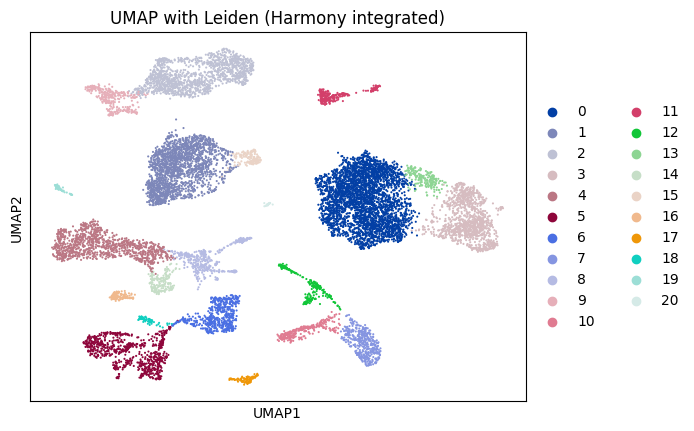

In [143]:
# Re-run clustering on Harmony integrated data
print("-> Re-running clustering on Harmony integrated data...")

# Recompute neighbors graph using the Harmony corrected embeddings
sc.pp.neighbors(adata_harmony, use_rep='X_pca_harmony')

# Recompute UMAP embedding
sc.tl.umap(adata_harmony)

# Recompute Leiden clustering
sc.tl.leiden(adata_harmony, key_added='leiden_harmony', resolution=0.4)

print("✅ Clustering on Harmony integrated data complete.")

# Evaluate clustering metrics against original clusters
labels_known = adata.obs['cluster'].astype(str) # Use original adata for known labels
labels_harmony_leiden = adata_harmony.obs['leiden_harmony'].astype(str)

# Ensure the order of cells is the same
labels_known = labels_known[adata_harmony.obs_names]


print("\n--- Clustering Metrics (Leiden on Harmony integrated data) ---")
ari_harmony = metrics.adjusted_rand_score(labels_known, labels_harmony_leiden)
# Silhouette score can be computed on the Harmony corrected embeddings
silhouette_harmony = metrics.silhouette_score(adata_harmony.obsm['X_pca_harmony'], labels_harmony_leiden, metric='euclidean')


print(f"   Adjusted Rand Index (ARI): {ari_harmony:.4f}")
print(f"   Silhouette Score: {silhouette_harmony:.4f}")

# Visualize UMAP with new clusters
sc.pl.umap(adata_harmony, color='leiden_harmony', title='UMAP with Leiden (Harmony integrated)', show=True)

### Evaluate Marker Selection after Harmony

In [144]:
# Find marker genes for the most enriched cluster at Day 0 after amputation in the Harmony integrated data
CLUSTER_KEY_HARMONY = 'leiden_harmony'

# Create the Contingency Table for Day 0 after amputation enrichment
# Use 'DaysPostAmputation' and filter for '0'
adata_harmony.obs['Is_Day0'] = adata_harmony.obs['DaysPostAmputation'].astype(str).apply(
    lambda x: 'Day_0' if x == '0' else 'Other_Days'
).astype('category')

contingency_table_harmony = pd.crosstab(
    index=adata_harmony.obs[CLUSTER_KEY_HARMONY],
    columns=adata_harmony.obs['Is_Day0'],
    normalize=False
)

# Perform Fisher's Exact Test for Day 0 after amputation Enrichment
total_day0_harmony = contingency_table_harmony['Day_0'].sum()
total_other_days_harmony = contingency_table_harmony['Other_Days'].sum()
results_harmony = {}
p_values_harmony = []

print("-> Running Fisher's Exact Test for Day 0 after amputation Enrichment on Harmony data...")

for cluster_id in contingency_table_harmony.index:
    n_cluster_day0_harmony = contingency_table_harmony.loc[cluster_id, 'Day_0']
    n_cluster_other_harmony = contingency_table_harmony.loc[cluster_id, 'Other_Days']

    n_other_day0_harmony = total_day0_harmony - n_cluster_day0_harmony
    n_other_other_harmony = total_other_days_harmony - n_cluster_other_harmony

    table_harmony = [
        [n_cluster_day0_harmony, n_cluster_other_harmony],
        [n_other_day0_harmony, n_other_other_harmony]
    ]

    or_val_harmony, p_val_harmony = fisher_exact(table_harmony, alternative='greater')
    p_values_harmony.append(p_val_harmony)

    results_harmony[cluster_id] = {
        'N_Day0': n_cluster_day0_harmony,
        'N_Other_Days': n_cluster_other_harmony,
        'OR_Day0_v_OtherDays': or_val_harmony,
    }

# Post-processing and Filtering
enrichment_df_harmony = pd.DataFrame.from_dict(results_harmony, orient='index')
_, fdr_pvalues_harmony, _, _ = multipletests(p_values_harmony, method='fdr_bh')
enrichment_df_harmony['FDR_Day0_Enriched'] = fdr_pvalues_harmony

SIGNIFICANCE_THRESHOLD = 0.05 # Use the same threshold as before
enrichment_df_harmony['Is_Day0_ROC_Candidate'] = (
    (enrichment_df_harmony['FDR_Day0_Enriched'] < SIGNIFICANCE_THRESHOLD) &
    (enrichment_df_harmony['OR_Day0_v_OtherDays'] > 1)
)

final_df_harmony = enrichment_df_harmony.sort_values(by='OR_Day0_v_OtherDays', ascending=False)

print("\n--- Day 0 after amputation Enrichment for ROC Candidates (Harmony) ---")
print(final_df_harmony[['N_Day0', 'N_Other_Days', 'OR_Day0_v_OtherDays', 'FDR_Day0_Enriched', 'Is_Day0_ROC_Candidate']])

# Get the list of clusters identified as Day 0 ROC Candidates
day0_roc_candidates_harmony = final_df_harmony[final_df_harmony['Is_Day0_ROC_Candidate']].index.tolist()
print(f"\n✅ Clusters Statistically Enriched in Day 0 after amputation (Harmony): {day0_roc_candidates_harmony}")


# Now, find marker genes for each of the TOP 3 Day 0 ROC Candidate clusters
for TARGET_ROC_CLUSTER_HARMONY in day0_roc_candidates_harmony[:3]:
    GROUPBY_KEY_HARMONY = CLUSTER_KEY_HARMONY

    print(f"\n--- Running DE for ROC Candidate Cluster {TARGET_ROC_CLUSTER_HARMONY} vs. All Other Cells (Harmony data) ---")

    # Method 1: Wilcoxon Rank-Sum Test
    print("-> Method 1: Wilcoxon Rank-Sum Test...")
    sc.tl.rank_genes_groups(
        adata_harmony,
        groupby=GROUPBY_KEY_HARMONY,
        groups=[TARGET_ROC_CLUSTER_HARMONY],
        reference='rest',
        method='wilcoxon',
        key_added=f'harmony_day0_wilcoxon_genes_{TARGET_ROC_CLUSTER_HARMONY}'
    )

    # Method 2: T-test
    print("-> Method 2: T-test...")
    sc.tl.rank_genes_groups(
        adata_harmony,
        groupby=GROUPBY_KEY_HARMONY,
        groups=[TARGET_ROC_CLUSTER_HARMONY],
        reference='rest',
        method='t-test',
        key_added=f'harmony_day0_ttest_genes_{TARGET_ROC_CLUSTER_HARMONY}'
    )

    # Extract and print top markers
    top_harmony_day0_wilcoxon = get_top_markers(adata_harmony, f'harmony_day0_wilcoxon_genes_{TARGET_ROC_CLUSTER_HARMONY}', group_id=TARGET_ROC_CLUSTER_HARMONY, n_genes=40)
    top_harmony_day0_ttest = get_top_markers(adata_harmony, f'harmony_day0_ttest_genes_{TARGET_ROC_CLUSTER_HARMONY}', group_id=TARGET_ROC_CLUSTER_HARMONY, n_genes=40)

    print(f"\nTop 40 Wilcoxon Markers (Harmony, Cluster {TARGET_ROC_CLUSTER_HARMONY}):")
    print(top_harmony_day0_wilcoxon)

    print(f"\nTop 40 T-test Markers (Harmony, Cluster {TARGET_ROC_CLUSTER_HARMONY}):")
    print(top_harmony_day0_ttest)

    # Compare with Supplementary Table 3
    table3_genes_found_harmony_day0 = []
    ROC_markers = df_gene_map['ROC markers'] # Assuming df_gene_map is still available

    for index, row in ROC_markers.iterrows():
        value = row.values[0]
        if (value in remove_dot(top_harmony_day0_wilcoxon)) or (value in remove_dot(top_harmony_day0_ttest)):
            table3_genes_found_harmony_day0.append(value)

    print(f"\n--- Comparison with Supplementary Table 3 (Harmony, Cluster {TARGET_ROC_CLUSTER_HARMONY}) ---")
    print(f"Found {len(table3_genes_found_harmony_day0)} out of {len(ROC_markers.iloc[:,0])} in table 3")
    print(f"Percentage {100*len(table3_genes_found_harmony_day0)/len(ROC_markers.iloc[:,0]):.2f}%")

-> Running Fisher's Exact Test for Day 0 after amputation Enrichment on Harmony data...

--- Day 0 after amputation Enrichment for ROC Candidates (Harmony) ---
    N_Day0  N_Other_Days  OR_Day0_v_OtherDays  FDR_Day0_Enriched  \
19      54             3             2.74e+01           1.16e-17   
15     109            42             3.97e+00           2.84e-15   
16      73            34             3.26e+00           9.34e-09   
3      724           426             2.81e+00           6.67e-60   
18      46            31             2.24e+00           7.83e-04   
6      313           231             2.10e+00           1.04e-16   
14     102            79             1.96e+00           1.53e-05   
1      972           952             1.66e+00           1.58e-23   
5      354           413             1.31e+00           4.69e-04   
9      126           181             1.05e+00           7.64e-01   
0     1349          2072             9.73e-01           1.00e+00   
20      13            23

### MAGIC denoise

In [145]:
# Implement MAGIC for denoising

print("-> Applying MAGIC for denoising...")
# Make a copy to keep the original data
adata_magic = adata_copy.copy()

# MAGIC requires normalized data, which we already have in adata_copy
# It's often recommended to run MAGIC on highly variable genes
# Ensure highly variable genes are computed if not already done
if 'highly_variable' not in adata_magic.var.columns:
    sc.pp.highly_variable_genes(adata_magic, n_top_genes=2000)

# Subset to highly variable genes for MAGIC
adata_magic = adata_magic[:, adata_magic.var.highly_variable].copy()

# Run MAGIC
sc.external.pp.magic(adata_magic, n_pca=50)  # Using n_pca=50 as used in previous PCA step

print("✅ MAGIC denoising applied.")

-> Applying MAGIC for denoising...


ImportError: Please install magic package via `pip install magic-impute`

### Evaluate Clustering after MAGIC

In [ ]:
# Re-run clustering on MAGIC denoised data
print("-> Re-running clustering on MAGIC denoised data...")

# Recompute neighbors graph on the denoised data
sc.pp.neighbors(adata_magic)

# Recompute UMAP embedding
sc.tl.umap(adata_magic)

# Recompute Leiden clustering
sc.tl.leiden(adata_magic, key_added='leiden_magic', resolution=0.4)

print("✅ Clustering on MAGIC denoised data complete.")

# Evaluate clustering metrics against original clusters
labels_known = adata.obs['cluster'].astype(str) # Use original adata for known labels
labels_magic_leiden = adata_magic.obs['leiden_magic'].astype(str)

# Ensure the order of cells is the same
labels_known = labels_known[adata_magic.obs_names]


print("\n--- Clustering Metrics (Leiden on MAGIC denoised data) ---")
ari_magic = metrics.adjusted_rand_score(labels_known, labels_magic_leiden)
# Silhouette score requires the PCA embedding, which we ran before MAGIC.
# It's more appropriate to compute silhouette on the denoised expression matrix directly or a new PCA on denoised data.
# Let's re-run PCA on the MAGIC-denoised data for a proper silhouette score.
sc.pp.pca(adata_magic, n_comps=50)
silhouette_magic = metrics.silhouette_score(adata_magic.obsm['X_pca'], labels_magic_leiden, metric='euclidean')


print(f"   Adjusted Rand Index (ARI): {ari_magic:.4f}")
print(f"   Silhouette Score: {silhouette_magic:.4f}")

# Visualize UMAP with new clusters
sc.pl.umap(adata_magic, color='leiden_magic', title='UMAP with Leiden (MAGIC denoised)', show=True)

### Evaluate Marker Selection after MAGIC

In [ ]:
# Find marker genes for the most quiescent cluster after MAGIC
# First, identify the most quiescent cluster in the MAGIC denoised data
CLUSTER_KEY_MAGIC = 'leiden_magic'

# Create the Contingency Table for Quiescent (G1) enrichment
adata_magic.obs['Is_Quiescent'] = adata_magic.obs['CellCyclePhase'].astype(str).apply(
    lambda x: 'Quiescent_G1' if x in QUIESCENT_PHASE else 'Other_Phase'
).astype('category')

contingency_table_magic = pd.crosstab(
    index=adata_magic.obs[CLUSTER_KEY_MAGIC],
    columns=adata_magic.obs['Is_Quiescent'],
    normalize=False
)

# Perform Fisher's Exact Test for Quiescent (G1) Enrichment
total_quiescent_magic = contingency_table_magic['Quiescent_G1'].sum()
total_other_phase_magic = contingency_table_magic['Other_Phase'].sum()
results_magic = {}
p_values_magic = []

print("-> Running Fisher's Exact Test for Quiescent (G1) Enrichment on MAGIC data...")

for cluster_id in contingency_table_magic.index:
    n_cluster_quiescent_magic = contingency_table_magic.loc[cluster_id, 'Quiescent_G1']
    n_cluster_other_magic = contingency_table_magic.loc[cluster_id, 'Other_Phase']

    n_other_quiescent_magic = total_quiescent_magic - n_cluster_quiescent_magic
    n_other_other_magic = total_other_phase_magic - n_cluster_other_magic

    table_magic = [
        [n_cluster_quiescent_magic, n_cluster_other_magic],
        [n_other_quiescent_magic, n_other_other_magic]
    ]

    or_val_magic, p_val_magic = fisher_exact(table_magic, alternative='greater')
    p_values_magic.append(p_val_magic)

    results_magic[cluster_id] = {
        'N_Quiescent_G1': n_cluster_quiescent_magic,
        'N_Other_Phase': n_cluster_other_magic,
        'OR_Quiescent_v_Other': or_val_magic,
    }

# Post-processing and Filtering
enrichment_df_magic = pd.DataFrame.from_dict(results_magic, orient='index')
_, fdr_pvalues_magic, _, _ = multipletests(p_values_magic, method='fdr_bh')
enrichment_df_magic['FDR_Quiescent_Enriched'] = fdr_pvalues_magic

SIGNIFICANCE_THRESHOLD = 0.05 # Use the same threshold as before
enrichment_df_magic['Is_Quiescent_ROC'] = (
    (enrichment_df_magic['FDR_Quiescent_Enriched'] < SIGNIFICANCE_THRESHOLD) &
    (enrichment_df_magic['OR_Quiescent_v_Other'] > 1)
)

final_df_magic = enrichment_df_magic.sort_values(by='OR_Quiescent_v_Other', ascending=False)

print("\n--- Quiescent (G1) Enrichment for ROC Candidates (MAGIC) ---")
print(final_df_magic[['N_Quiescent_G1', 'N_Other_Phase', 'OR_Quiescent_v_Other', 'FDR_Quiescent_Enriched', 'Is_Quiescent_ROC']].head()) # Display top few

most_quiescent_cluster_magic = final_df_magic.index[0]
print(f"\n✅ The most quiescent candidate cluster (highest OR) in MAGIC data is: {most_quiescent_cluster_magic}")


# Now, find marker genes for this cluster
TARGET_ROC_CLUSTER_MAGIC = most_quiescent_cluster_magic
GROUPBY_KEY_MAGIC = CLUSTER_KEY_MAGIC

print(f"\n--- Running DE for ROC Cluster {TARGET_ROC_CLUSTER_MAGIC} vs. All Other Cells (MAGIC data) ---")

# Method 1: Wilcoxon Rank-Sum Test
print("-> Method 1: Wilcoxon Rank-Sum Test...")
sc.tl.rank_genes_groups(
    adata_magic,
    groupby=GROUPBY_KEY_MAGIC,
    groups=[TARGET_ROC_CLUSTER_MAGIC],
    reference='rest',
    method='wilcoxon',
    key_added='magic_roc_wilcoxon_genes'
)

# Method 2: T-test
print("-> Method 2: T-test...")
sc.tl.rank_genes_groups(
    adata_magic,
    groupby=GROUPBY_KEY_MAGIC,
    groups=[TARGET_ROC_CLUSTER_MAGIC],
    reference='rest',
    method='t-test',
    key_added='magic_roc_ttest_genes'
)

# Extract and print top markers
top_magic_roc_wilcoxon = get_top_markers(adata_magic, 'magic_roc_wilcoxon_genes', group_id=TARGET_ROC_CLUSTER_MAGIC, n_genes=40)
top_magic_roc_ttest = get_top_markers(adata_magic, 'magic_roc_ttest_genes', group_id=TARGET_ROC_CLUSTER_MAGIC, n_genes=40)

print("\nTop 40 Wilcoxon Markers (MAGIC):")
print(top_magic_roc_wilcoxon)

print("\nTop 40 T-test Markers (MAGIC):")
print(top_magic_roc_ttest)

# Compare with Supplementary Table 3
table3_genes_found_magic = []
ROC_markers = df_gene_map['ROC markers'] # Assuming df_gene_map is still available

for index, row in ROC_markers.iterrows():
    value = row.values[0]
    if (value in remove_dot(top_magic_roc_wilcoxon)) or (value in remove_dot(top_magic_roc_ttest)):
        table3_genes_found_magic.append(value)

print(f"\n--- Comparison with Supplementary Table 3 (MAGIC) ---")
print(f"Found {len(table3_genes_found_magic)} out of {len(ROC_markers.iloc[:,0])} in table 3")
print(f"Percentage {100*len(table3_genes_found_magic)/len(ROC_markers.iloc[:,0]):.2f}%")

Comparing the Leiden clustering results obtained before denoising/integration (from Section 2) with the Leiden clustering results obtained after applying denoising (Cell Cycle Regression) and batch integration techniques (from Section 3). Using metrics like Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) to quantify the similarity between the different sets of cluster assignments.

In [ ]:
print("\n--- Comparing Leiden Clusters (Original vs. Denoised/Integrated) ---")

# Ensure original Leiden clusters are available (assuming 'leiden_clusters' in adata_copy.obs from Section 2)
if 'leiden_clusters' in adata_copy.obs:
    denoised_leiden_labels = adata_denoise.obs['leiden_denoised_cc'].astype(str)
    integrated_leiden_labels = adata_integ.obs['leiden_integrated_batch'].astype(str)
    for key, value in {
        "leiden":labels_leiden,
        "Denoised Leiden": denoised_leiden_labels,
        "Integrated Leiden": integrated_leiden_labels,
        }.items():
      NMI = metrics.normalized_mutual_info_score(labels_known, value)
      ARI = metrics.adjusted_rand_score(labels_known, value)
      print(f"\n{key} - NMI: {NMI:.3f} - ARI: {ARI:.3f}")
else:
    print("Error: 'leiden_clusters' not found in adata_copy.obs. Please run Section 2 first.")


In [ ]:
sc.tl.umap(adata_denoise) # UMAP embedding
sc.pl.umap(adata_denoise,
                color=['leiden_denoised_cc'],
                title=['Leiden_denoised_cc'],
                show=True,
            ncols=1)

In [ ]:
sc.tl.umap(adata_integ) # UMAP embedding
sc.pl.umap(adata_integ,
                color=['leiden_integrated_batch'],
                title=['Leiden_integrated_batch'],
                show=True,
            ncols=1)